# Run to start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/Projects/Projects4N/Energy_DS/Project_Weather_station'

In [ ]:
%cd $base_dir

/content/drive/MyDrive/Projects/Projects4N/Energy_DS/Project_Weather_station


In [ ]:
from os.path import join as Path
from tqdm import tqdm
import pandas as pd
import xarray as xr
import numpy as np
from scipy.signal import find_peaks
import pickle
import matplotlib.pyplot as plt

In [ ]:
def stack_all_vars(path_to_city_dir):
    # dir = 'weather/paris/'
    dir = path_to_city_dir
    list_of_files = ['blh.nc',	'd2m.nc',	'skt.nc',	'sp.nc',  'ssrd.nc',	
                    't2m.nc', 'tcc.nc',	'tp.nc',  'u10.nc',  'v10.nc']

    ds = xr.open_dataset(Path(base_dir, dir, list_of_files[0]))
    df = ds.to_dataframe()
    del ds
    df = df.droplevel([1, 2])
    df_with_all_vars = df
    del df

    for f in list_of_files[1:2]:
        ds = xr.open_dataset(Path(base_dir, dir, f))
        df = ds.to_dataframe()
        del ds
        df = df.droplevel([1, 2])
        df_with_all_vars = df_with_all_vars.join(df[df.columns[0]])
        del df

    for f in list_of_files[2:]:
        ds = xr.open_dataset(Path(base_dir, dir, f))
        df = ds.to_dataframe()
        del ds
        df = df.droplevel([0,1])
        df_with_all_vars = df_with_all_vars.join(df[df.columns[0]])
        del df
    
    df_with_all_vars = df_with_all_vars.dropna()
    return df_with_all_vars

# Project Objective



is to infer the weather in Paris using the other stations in case the weather station in Paris breaks down. 

There are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.


**Problem statement:**

Let's suppose station in Paris breaks down and cannot measure weather variables during a time period after which it is fixed. Thus there will be a gap in recording weather variables in Paris even after station gets fixed. ML methods can be used to get hourly estimates of weather variables to fill this gap. Data from other 4 weather stations, that work properly, and data already recorded at Paris station before it stopped working will be used to prepare models. 

The difficulty of the 3 problems below is increasing:

**Problem №1:** 

1) The time period of the Paris station being out of service is 24 hours.

2) Only one weather variable, for example, 't2m' will be inferred on hourly basis from the real time data from the other 4 stations and past data from Paris station.

**Problem №2:**

The same thing but now gap will be 1 year long:

1) The time period of the Paris station being out of service is 1 year.

2) Only one weather variable, for example, 't2m' will be inferred on hourly basis from the real time data from the other 4 stations and past data from Paris. 

3) Now, 't2m' values recorded during the week before the day of prediction are not available. 't2m' values recorded during last week are usually similar to the ones we need to predict today, but differ from temperatures recorede one or several months ago. In this setting for the last day of the gap the closest recorded data is 1 year ago.

**Problem №3:**

Actually, we need to fill all the gaps in the weather recording, so all weather variables must be inferred on hourly basis. 

Let's keep the same gap length as in previous Problem #2.



# Dataset assessment

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

**The meaning of the weather variables:**

* blh - Boundary layer height
* d2m - 2m dewpoint temperature
* skt - Skin temperature
* sp - Surface pressure
* ssrd - Surface solar radiation downwards
* t2m - 2m temperature
* tcc - Total cloud cover
* tp - Total precipitation
* u10 - 10m u-component of wind
* v10 - 10m v-component of wind

https://sonra.io/data-marketplace/era5-variables/

blh, ssrd and tp start from 7:00 time and, thus, are Forecast variables.

In [ ]:
!cat weather/readme.md

# Weather data set

This data set comes from ERA5 and contains surface data for 5 cities:

- Berlin
- Brest
- London
- Marseille
- Paris

There is 1 netcdf file per variable per city.
Each file has 40 years of data (except Paris: 41 years)

Some variables are *Analysis* variables
Some variables are *Forecast* variables and are shifted by 3h compared to analysis variable. (you need to rely on the timestamp that is in the netcdf file).

You can use the xarray library to load netcdf files in python and you can then convert this data set into a pandas DataFrame.


## Tables with data

After removing the lat and lon values from index we have the follwing tables for each variable:

In [ ]:
from IPython.display import display, Markdown
import pandas as pd

def head(df, n_rows):
    display(Markdown("**whole table (below):** {} rows × {} columns".format(len(df), len(df.columns))))
    display(df.head(n_rows))

In [ ]:
from os.path import join as Path
from tqdm import tqdm
import pandas as pd
import xarray as xr


dir = 'weather/paris/'
list_of_files = ['blh.nc',	'd2m.nc',	'skt.nc',	'sp.nc',  'ssrd.nc',	
                 't2m.nc', 'tcc.nc',	'tp.nc',  'u10.nc',  'v10.nc']

for f in list_of_files[:2]:
    ds = xr.open_dataset(Path(base_dir, dir, f))
    df = ds.to_dataframe()
    del ds
    df = df.droplevel([1, 2])
    head(df, 5)
    print(df.index.max())
    del df

for f in list_of_files[2:]:
    ds = xr.open_dataset(Path(base_dir, dir, f))
    df = ds.to_dataframe()
    del ds
    df = df.droplevel([0,1])
    head(df, 5)
    print(df.index.max())
    del df

**whole table (below):** 359424 rows × 1 columns

,blh
time,
1980-01-01 07:00:00,48.789497
1980-01-01 08:00:00,45.450958
1980-01-01 09:00:00,52.533615
1980-01-01 10:00:00,86.198097
1980-01-01 11:00:00,158.100311


2021-01-01 06:00:00


**whole table (below):** 359424 rows × 1 columns

,d2m
time,
1980-01-01 00:00:00,272.332703
1980-01-01 01:00:00,272.302704
1980-01-01 02:00:00,272.056641
1980-01-01 03:00:00,271.807556
1980-01-01 04:00:00,271.532471


2020-12-31 23:00:00


**whole table (below):** 359424 rows × 1 columns

,skt
time,
1980-01-01 00:00:00,271.886169
1980-01-01 01:00:00,271.277069
1980-01-01 02:00:00,271.015686
1980-01-01 03:00:00,270.778687
1980-01-01 04:00:00,269.853119


2020-12-31 23:00:00


**whole table (below):** 359424 rows × 1 columns

,sp
time,
1980-01-01 00:00:00,100071.015625
1980-01-01 01:00:00,100026.843750
1980-01-01 02:00:00,99995.453125
1980-01-01 03:00:00,99981.320312
1980-01-01 04:00:00,99924.750000


2020-12-31 23:00:00


**whole table (below):** 359424 rows × 1 columns

,ssrd
time,
1980-01-01 07:00:00,0.0
1980-01-01 08:00:00,2240.0
1980-01-01 09:00:00,161024.0
1980-01-01 10:00:00,470080.0
1980-01-01 11:00:00,675200.0


2021-01-01 06:00:00


**whole table (below):** 359424 rows × 1 columns

,t2m
time,
1980-01-01 00:00:00,273.624573
1980-01-01 01:00:00,273.590820
1980-01-01 02:00:00,273.077484
1980-01-01 03:00:00,272.647949
1980-01-01 04:00:00,272.320129


2020-12-31 23:00:00


**whole table (below):** 359424 rows × 1 columns

,tcc
time,
1980-01-01 00:00:00,1.000000
1980-01-01 01:00:00,0.986572
1980-01-01 02:00:00,1.000000
1980-01-01 03:00:00,0.989990
1980-01-01 04:00:00,0.916901


2020-12-31 23:00:00


**whole table (below):** 359424 rows × 1 columns

,tp
time,
1980-01-01 07:00:00,0.0
1980-01-01 08:00:00,0.0
1980-01-01 09:00:00,0.0
1980-01-01 10:00:00,0.0
1980-01-01 11:00:00,0.0


2021-01-01 06:00:00


**whole table (below):** 359424 rows × 1 columns

,u10
time,
1980-01-01 00:00:00,1.821228
1980-01-01 01:00:00,1.522354
1980-01-01 02:00:00,1.478912
1980-01-01 03:00:00,1.310043
1980-01-01 04:00:00,1.426117


2020-12-31 23:00:00


**whole table (below):** 359424 rows × 1 columns

,v10
time,
1980-01-01 00:00:00,0.593918
1980-01-01 01:00:00,0.792664
1980-01-01 02:00:00,0.811569
1980-01-01 03:00:00,0.710587
1980-01-01 04:00:00,0.915924


2020-12-31 23:00:00


We see that 3 variables (blh, ssrd and tp) start from 7:00 time and, thus, are *Forecast* variables and the other 7 ones are *Analysis* variables (as mentioned in readme). 

In [ ]:
def print_start_end(path2dir):
    print(path2dir)
    print()

    ds = xr.open_dataset(Path(base_dir, dir, 't2m.nc'))
    df = ds.to_dataframe()
    del ds
    df = df.droplevel([0,1])
    print('Time range: {} - {}'.format(df.index.min(), df.index.max()))
    del df

In [ ]:
dir = 'weather/paris/'
print_start_end(dir)

weather/paris/

Time range: 1980-01-01 00:00:00 - 2020-12-31 23:00:00


In [ ]:
dir = 'weather/berlin/'
print_start_end(dir)

weather/berlin/

Time range: 1980-01-01 00:00:00 - 2019-12-31 23:00:00


In [ ]:
dir = 'weather/london/'
print_start_end(dir)

weather/london/

Time range: 1980-01-01 00:00:00 - 2019-12-31 23:00:00


In [ ]:
dir = 'weather/marseille/'
print_start_end(dir)

weather/marseille/

Time range: 1980-01-01 00:00:00 - 2019-12-31 23:00:00


In [ ]:
dir = 'weather/brest/'
print_start_end(dir)

weather/brest/

Time range: 1980-01-01 00:00:00 - 2019-12-31 23:00:00


**Train** / **Val** / **Test**

The last year (2019) that is present for all cities will be used as the test set.

The 19 years before, i.e. in range 1980-2018, will be used as train and val in for cross-validation.

#### **Visualization**

Selected features plotted at different scales:
one year, one month, one day. 

Data has periods equal to one year and one 24 hours.

In [ ]:
def stack_all_vars(path_to_city_dir):
    # dir = 'weather/paris/'
    dir = path_to_city_dir
    list_of_files = ['blh.nc',	'd2m.nc',	'skt.nc',	'sp.nc',  'ssrd.nc',	
                    't2m.nc', 'tcc.nc',	'tp.nc',  'u10.nc',  'v10.nc']

    ds = xr.open_dataset(Path(base_dir, dir, list_of_files[0]))
    df = ds.to_dataframe()
    del ds
    df = df.droplevel([1, 2])
    df_with_all_vars = df
    del df

    for f in list_of_files[1:2]:
        ds = xr.open_dataset(Path(base_dir, dir, f))
        df = ds.to_dataframe()
        del ds
        df = df.droplevel([1, 2])
        df_with_all_vars = df_with_all_vars.join(df[df.columns[0]])
        del df

    for f in list_of_files[2:]:
        ds = xr.open_dataset(Path(base_dir, dir, f))
        df = ds.to_dataframe()
        del ds
        df = df.droplevel([0,1])
        df_with_all_vars = df_with_all_vars.join(df[df.columns[0]])
        del df
    
    df_with_all_vars = df_with_all_vars.dropna()
    return df_with_all_vars


In [ ]:
df_all_vars_paris = stack_all_vars('weather/paris/')

Let's visualize the selected features:

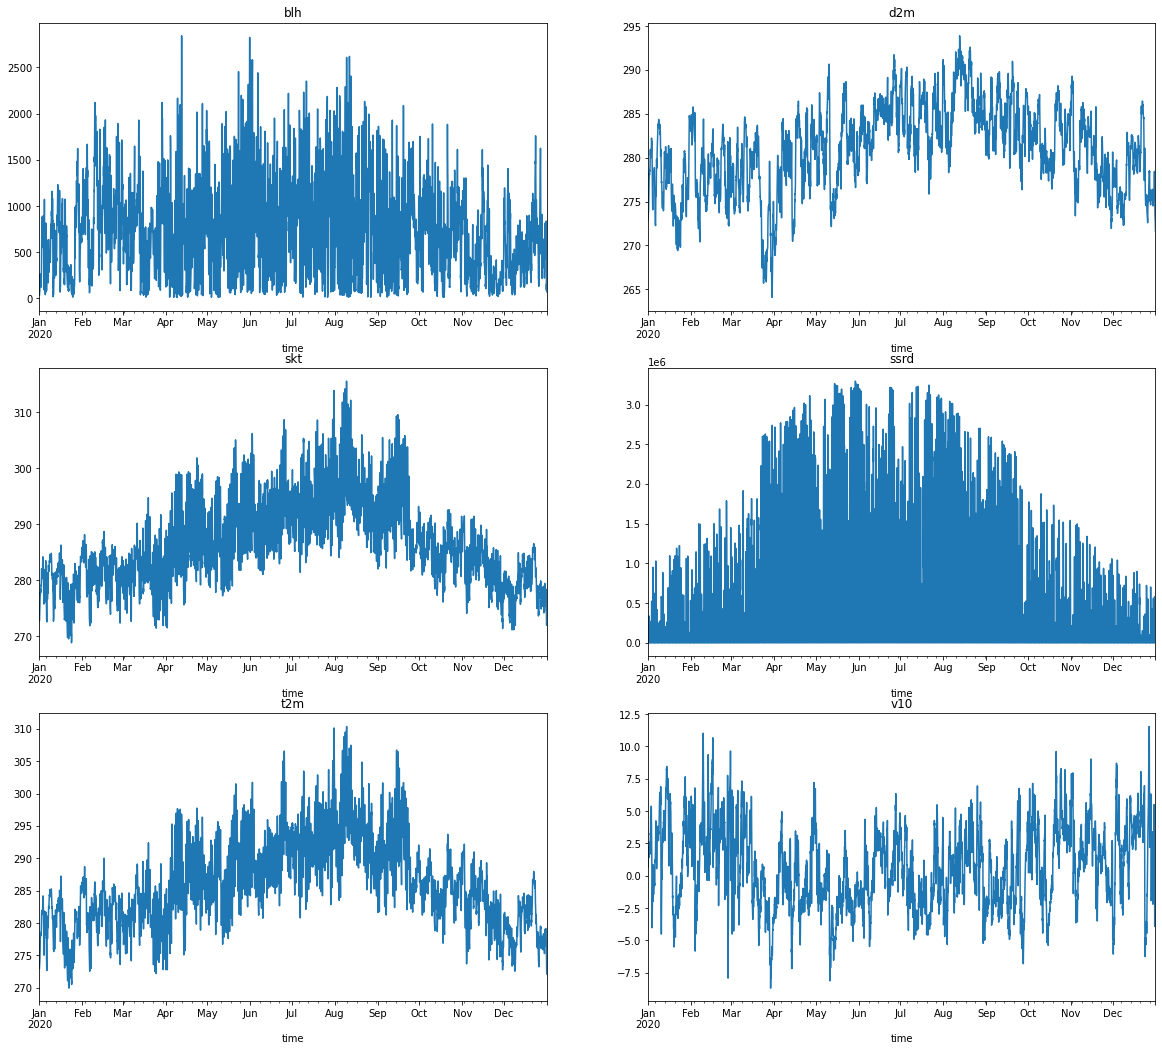

In [ ]:
import matplotlib.pyplot as plt

nrows=3
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 18))

selected_features = ['blh', 'd2m', 'skt', 'ssrd', 't2m', 
                     'v10']

for i, feature in enumerate(selected_features):  
    axes[i // ncols, i % ncols].set_title(feature)
    df_all_vars_paris.loc[df_all_vars_paris.index.year==2020, 
                          feature].plot(use_index=True, ax=axes[i // ncols, i % ncols])

In [ ]:
fig.savefig('pics/paris_year.png')

In [ ]:
!ls pics

paris_year.png


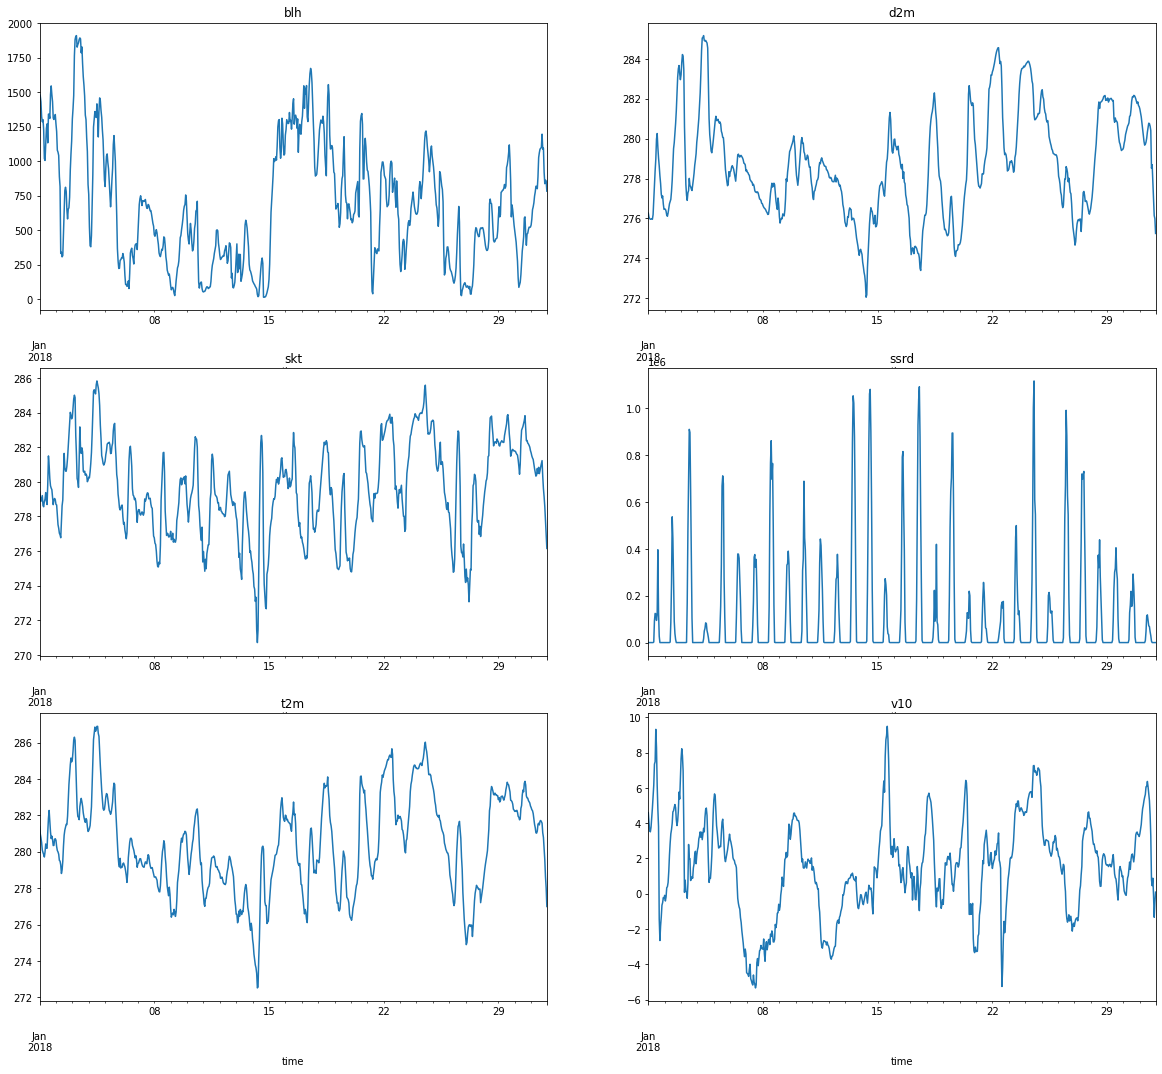

In [ ]:
import matplotlib.pyplot as plt

nrows=3
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 18))

selected_features = ['blh', 'd2m', 'skt', 'ssrd', 't2m', 'v10']

for i, feature in enumerate(selected_features):  
    axes[i // ncols, i % ncols].set_title(feature)
    df_all_vars_paris.loc[(df_all_vars_paris.index.year==2018) & (df_all_vars_paris.index.month==1),
                          feature].plot(use_index=True, ax=axes[i // ncols, i % ncols])

In [ ]:
fig.savefig('pics/paris_month.png')

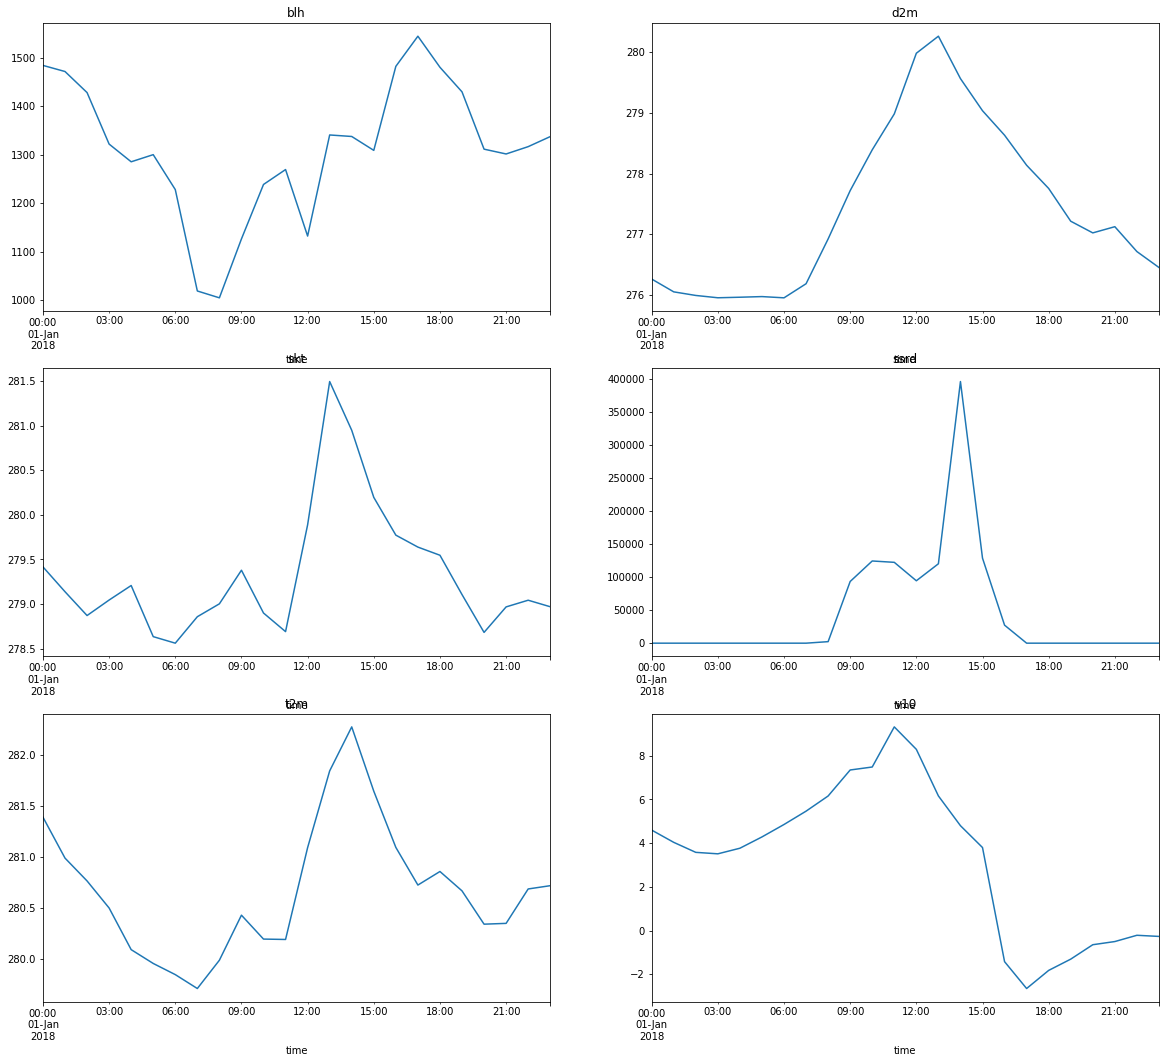

In [ ]:
import matplotlib.pyplot as plt

nrows=3
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 18))

selected_features = ['blh', 'd2m', 'skt', 'ssrd', 't2m', 'v10']

for i, feature in enumerate(selected_features):  
    axes[i // ncols, i % ncols].set_title(feature)
    df_all_vars_paris.loc[(df_all_vars_paris.index.year==2018) & 
                          (df_all_vars_paris.index.month==1) &
                          (df_all_vars_paris.index.day==1),
                          feature].plot(use_index=True, ax=axes[i // ncols, i % ncols])

In [ ]:
fig.savefig('pics/paris_day.png')

# Model assessment

To realistically assess the model performance we use cross-validation, where for each split of dataset validation set follows train set. For each split the model is trained on the train set and then MAE error is calculated on validation set. The number of splits is 10, so in total we obtain 10 values of MAE for different train/val data. Then we can assess the model with average and standart deviation of the MAEs.

The total number of years in dataset is 39 years,
validation folds are 1 year long and training folds are 29 years long. The last 40th year is not used in any way except for the evaluation of the model.

# Problem №1

Let's assume that Paris station is not working for 24 hours consecutively and after that it gets fixed. 

During this period the task is to infer one target variable in Paris, for example, 't2m' which is temperature at 2m height.

## Lasso regression

### Feature selection

is performed by calculating the correlation between target variable 't2m' and all other features with different lags. Only the ones with positive correlation where selected. This means that feature interactions were ignored and it is not optimal, because these interactions are not used by linear regression after selecting a subset of features.

In [ ]:
def stack_all_vars(path_to_city_dir):
    # dir = 'weather/paris/'
    dir = path_to_city_dir
    list_of_files = ['blh.nc',	'd2m.nc',	'skt.nc',	'sp.nc',  'ssrd.nc',	
                    't2m.nc', 'tcc.nc',	'tp.nc',  'u10.nc',  'v10.nc']

    ds = xr.open_dataset(Path(base_dir, dir, list_of_files[0]))
    df = ds.to_dataframe()
    del ds
    df = df.droplevel([1, 2])
    df_with_all_vars = df
    del df

    for f in list_of_files[1:2]:
        ds = xr.open_dataset(Path(base_dir, dir, f))
        df = ds.to_dataframe()
        del ds
        df = df.droplevel([1, 2])
        df_with_all_vars = df_with_all_vars.join(df[df.columns[0]])
        del df

    for f in list_of_files[2:]:
        ds = xr.open_dataset(Path(base_dir, dir, f))
        df = ds.to_dataframe()
        del ds
        df = df.droplevel([0,1])
        df_with_all_vars = df_with_all_vars.join(df[df.columns[0]])
        del df
    
    df_with_all_vars = df_with_all_vars.dropna()
    return df_with_all_vars


def compute_lagged_corrs(df_city1, feature_city2, lags_in_hours):
    cols = df_city1.columns
    df_lagged_corrs = pd.DataFrame(index = lags_in_hours, columns =cols)

    for lag in lags_in_hours:
        df_tmp = df_city1.shift(lag)
        df_tmp['foreign_feature_not_lagged'] = feature_city2
        # head(df_tmp, 5)
        lagged_corrs = df_tmp.corr()
        # print(lagged_corrs.loc['t2m_not_lagged', cols])
        df_lagged_corrs.iloc[lag] = lagged_corrs.loc['foreign_feature_not_lagged', cols]
        del df_tmp
    return df_lagged_corrs


def plot_lagged_corrs(df_lagged_corrs):
    ax = df_lagged_corrs.plot(use_index=True, figsize=(15, 8))
    ax.grid(axis='x', )

def find_lags_for_max_corr(all_lagged_corrs, selected_features):
    max_ids = []
    for col in selected_features:
        lags_for_max_corr, _ = find_peaks(all_lagged_corrs.loc[:, col].to_numpy())
        # print(lags_for_max_corr.shape)
        max_ids.append(lags_for_max_corr)

    tmp = pd.DataFrame(max_ids, index = selected_features)
    return tmp, max_ids

In [ ]:
features_per_city = {}
lags_per_city = {}

#### **Paris**

In order to calculate the correlation between all weather variables in a fixed location, they will be concatenated into one dataframe. It is done for Paris in the cell below on all time horizont (NaN values in the end and in the beginning are ignored).

In [ ]:
df_all_vars_paris = stack_all_vars('weather/paris/')

delete test set

In [ ]:
df_all_vars_paris = df_all_vars_paris[df_all_vars_paris.index.year <= 2018]

In [ ]:
# df_all_vars_paris

Let's look on lagged correlations between target variable and all lagged variables in Paris:

In [ ]:
lags_in_hours = np.arange(0, 24*7+7)
feature = df_all_vars_paris['t2m']
lagged_corr_paris = compute_lagged_corrs(df_all_vars_paris, feature, lags_in_hours)

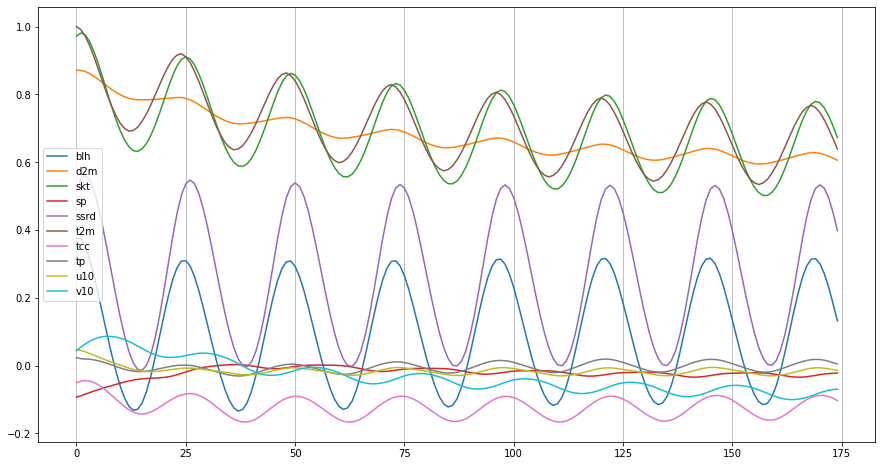

In [ ]:
plot_lagged_corrs(lagged_corr_paris)

We see high values of cross-correlation between 'blh', 'd2m', 'skt', 'ssrd' with 't2m' and auto-correlation for 't2m' in Paris dataset.
 

Maximum correlation corresponds to lags of length:

In [ ]:
selected_features = ['blh', 'd2m', 'skt', 'ssrd', 't2m']
lags_paris, lags_paris_list  =  find_lags_for_max_corr(lagged_corr_paris, selected_features)
lags_paris

,0,1,2,3,4,5,6,7
blh,25,49,73,97,121,145,169,NaN
d2m,24,48,72,96,120,144,168,NaN
skt,1,25,49,73,97,121,145,169.0
ssrd,2,26,50,74,98,122,146,170.0
t2m,24,48,72,96,120,144,168,NaN


In [ ]:
lags_paris_list[2] = np.delete(lags_paris_list[2], 0)
lags_paris_list[3] = np.delete(lags_paris_list[3], 0)

lags_paris_list = np.array(lags_paris_list)
lags_paris_list

array([[ 25,  49,  73,  97, 121, 145, 169],
       [ 24,  48,  72,  96, 120, 144, 168],
       [ 25,  49,  73,  97, 121, 145, 169],
       [ 26,  50,  74,  98, 122, 146, 170],
       [ 24,  48,  72,  96, 120, 144, 168]])

In [ ]:
features_per_city['paris'] = selected_features
lags_per_city['paris'] = lags_paris_list

#### **Berlin**

Let's do the same for another city - Berlin.

In [ ]:
df_all_vars = stack_all_vars('weather/berlin/')
df_all_vars = df_all_vars[df_all_vars.index.year <= 2018]

In [ ]:
lags_in_hours = np.arange(0, 24*7+7)
target_feature = df_all_vars_paris['t2m']
lagged_corrs_berlin = compute_lagged_corrs(df_all_vars, target_feature, lags_in_hours)

The cross-corelation between target variable in Paris and all variables in Berlin:

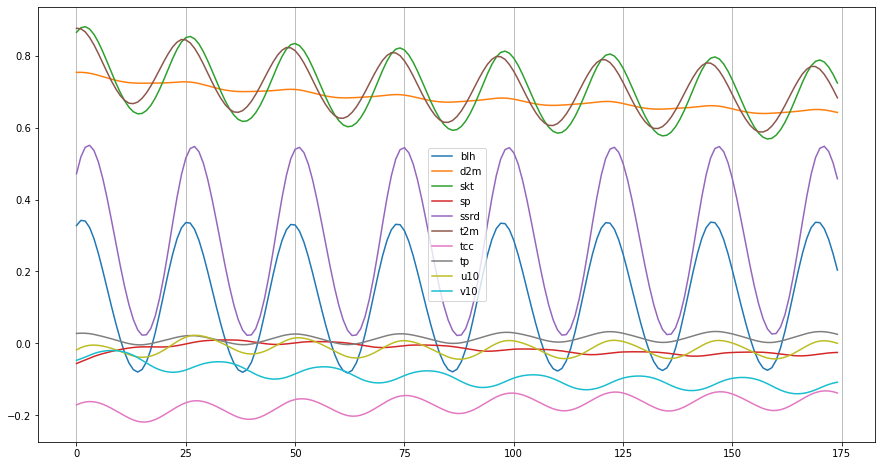

In [ ]:
plot_lagged_corrs(lagged_corrs_berlin)

In [ ]:
selected_features = ['blh', 'd2m', 'skt', 'ssrd', 't2m']
lags_max_corr, lags_list =  find_lags_for_max_corr(lagged_corrs_berlin, selected_features)
lags_max_corr

,0,1,2,3,4,5,6,7
blh,1,25,49,73,97,121,145,169.0
d2m,1,25,49,73,97,121,145,169.0
skt,2,26,50,74,98,122,146,170.0
ssrd,3,27,51,75,99,123,147,171.0
t2m,24,48,72,96,120,144,168,NaN


In [ ]:
lags_list[4] = np.insert(lags_list[4], 0, 0)

lags_list = np.array(lags_list)
lags_list

array([[  1,  25,  49,  73,  97, 121, 145, 169],
       [  1,  25,  49,  73,  97, 121, 145, 169],
       [  2,  26,  50,  74,  98, 122, 146, 170],
       [  3,  27,  51,  75,  99, 123, 147, 171],
       [  0,  24,  48,  72,  96, 120, 144, 168]])

In [ ]:
features_per_city['berlin'] = selected_features
lags_per_city['berlin'] = lags_list

#### **London**

In [ ]:
df_all_vars = stack_all_vars('weather/london/')
df_all_vars = df_all_vars[df_all_vars.index.year <= 2018]

In [ ]:
lags_in_hours = np.arange(0, 24*7+7)
target_feature = df_all_vars_paris['t2m']
lagged_corrs_london = compute_lagged_corrs(df_all_vars, target_feature, lags_in_hours)

The cross-corelation between target variable in Paris and all variables:

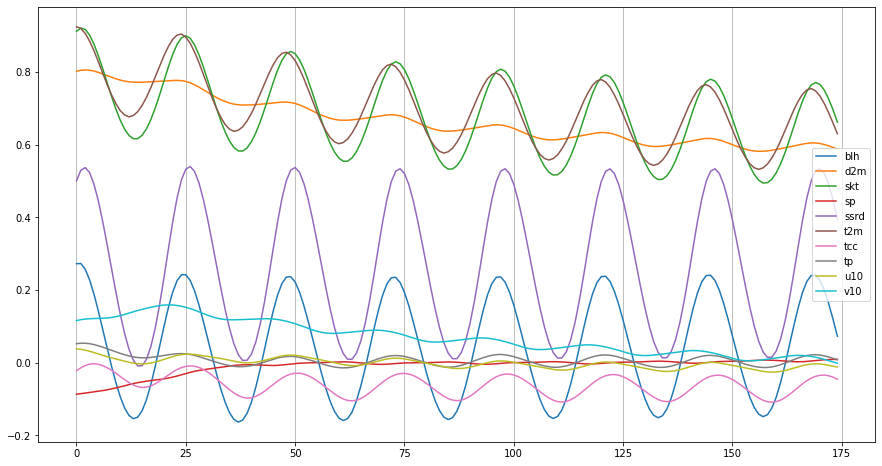

In [ ]:
plot_lagged_corrs(lagged_corrs_london)

In [ ]:
selected_features = ['blh', 'd2m', 'skt', 'ssrd', 't2m']
lags_max_corr, lags_list =  find_lags_for_max_corr(lagged_corrs_london, selected_features)
lags_max_corr

,0,1,2,3,4,5,6,7
blh,1,24,49,73,97,121,145,169.0
d2m,2,23,48,72,96,120,144,168.0
skt,1,25,49,73,97,121,145,169.0
ssrd,2,26,50,74,98,122,146,170.0
t2m,24,48,72,96,120,144,168,NaN


In [ ]:
lags_list[4] = np.insert(lags_list[4], 0, 0)

lags_list = np.array(lags_list)
lags_list

array([[  1,  24,  49,  73,  97, 121, 145, 169],
       [  2,  23,  48,  72,  96, 120, 144, 168],
       [  1,  25,  49,  73,  97, 121, 145, 169],
       [  2,  26,  50,  74,  98, 122, 146, 170],
       [  0,  24,  48,  72,  96, 120, 144, 168]])

In [ ]:
features_per_city['london'] = selected_features
lags_per_city['london'] = lags_list

#### **Brest**

In [ ]:
df_all_vars = stack_all_vars('weather/brest/')
df_all_vars = df_all_vars[df_all_vars.index.year <= 2018]

In [ ]:
lags_in_hours = np.arange(0, 24*7+7)
target_feature = df_all_vars_paris['t2m']
lagged_corrs_brest = compute_lagged_corrs(df_all_vars, target_feature, lags_in_hours)

The cross-corelation between target variable in Paris and all variables:

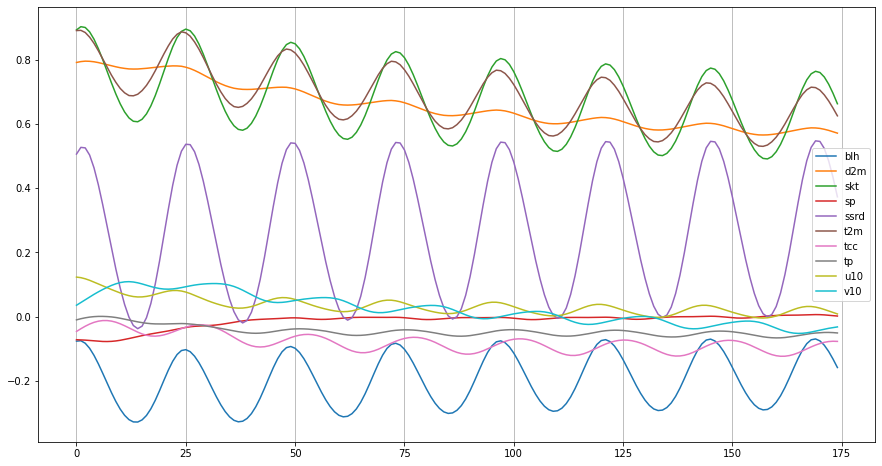

In [ ]:
plot_lagged_corrs(lagged_corrs_brest)

In [ ]:
selected_features = ['d2m', 'skt', 'ssrd', 't2m']
lags_max_corr, lags_list =  find_lags_for_max_corr(lagged_corrs_brest, selected_features)
lags_max_corr

,0,1,2,3,4,5,6,7
d2m,2,22,47,72,96,120,144,168
skt,1,25,49,73,97,121,145,169
ssrd,1,25,49,73,97,121,145,169
t2m,1,24,48,72,96,120,144,168


In [ ]:
lags_list = np.array(lags_list)
lags_list

array([[  2,  22,  47,  72,  96, 120, 144, 168],
       [  1,  25,  49,  73,  97, 121, 145, 169],
       [  1,  25,  49,  73,  97, 121, 145, 169],
       [  1,  24,  48,  72,  96, 120, 144, 168]])

In [ ]:
features_per_city['brest'] = selected_features
lags_per_city['brest'] = lags_list

#### **marseille**

In [ ]:
df_all_vars = stack_all_vars('weather/marseille/')
df_all_vars = df_all_vars[df_all_vars.index.year <= 2018]

In [ ]:
lags_in_hours = np.arange(0, 24*7+7)
target_feature = df_all_vars_paris['t2m']
lagged_corrs_marseille = compute_lagged_corrs(df_all_vars, target_feature, lags_in_hours)

The cross-corelation between target variable in Paris and all variables:

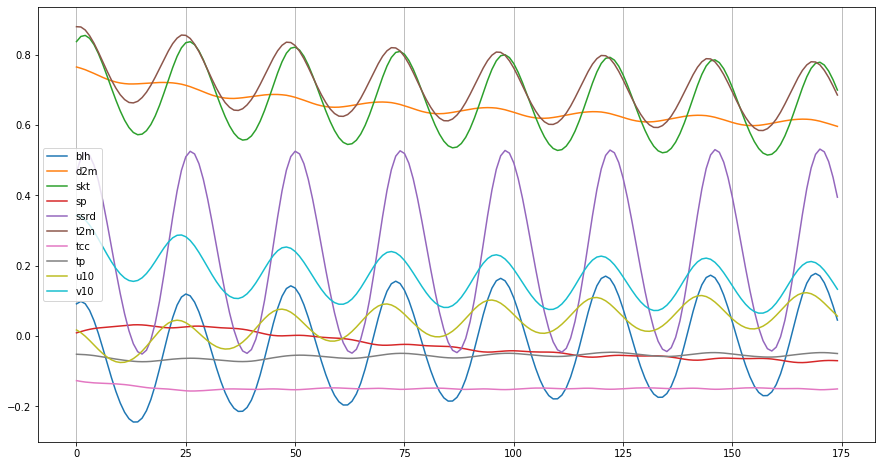

In [ ]:
plot_lagged_corrs(lagged_corrs_marseille)

In [ ]:
selected_features = ['blh', 'd2m', 'skt', 'ssrd', 't2m', 'v10', 'u10']
lags_max_corr, lags_list =  find_lags_for_max_corr(lagged_corrs_marseille, selected_features)
lags_max_corr

,0,1,2,3,4,5,6,7
blh,1,25,49,73,97,121,145,169.0
d2m,20,45,70,94,118,142,166,NaN
skt,2,26,50,74,98,122,146,170.0
ssrd,2,26,50,74,98,122,146,170.0
t2m,24,48,72,96,120,144,168,NaN
v10,24,48,72,96,120,144,168,NaN
u10,23,47,71,95,119,143,167,NaN


In [ ]:
ids = [1, 4,5,6]
for id in ids:
    lags_list[id] = np.insert(lags_list[id], 0, 0)

lags_list = np.array(lags_list)
lags_list

array([[  1,  25,  49,  73,  97, 121, 145, 169],
       [  0,  20,  45,  70,  94, 118, 142, 166],
       [  2,  26,  50,  74,  98, 122, 146, 170],
       [  2,  26,  50,  74,  98, 122, 146, 170],
       [  0,  24,  48,  72,  96, 120, 144, 168],
       [  0,  24,  48,  72,  96, 120, 144, 168],
       [  0,  23,  47,  71,  95, 119, 143, 167]])

In [ ]:
features_per_city['marseille'] = selected_features
lags_per_city['marseille'] = lags_list

#### **Save** selected feature lags per city

In [ ]:
import pickle

with open('selected_features/features_per_city.pkl', 'wb') as f:
    pickle.dump(features_per_city, f)

with open('selected_features/lags_per_city.pkl', 'wb') as f:
    pickle.dump(lags_per_city, f)

### Train set + feature scaling

In [ ]:
!ls selected_features

features_per_city.pkl  lags_per_city.pkl


In [ ]:
import pickle

with open(r'selected_features/features_per_city.pkl', 'rb') as f:
    features_per_city = pickle.load(f)

with open(r'selected_features/lags_per_city.pkl', 'rb') as f:
    lags_per_city = pickle.load(f)

First, let's create datasets for each city with selected features

In [ ]:
city_names = ['berlin','brest','london','marseille','paris']

In [ ]:
dataframes_per_city = {}

for city in tqdm(city_names):
    path_to_city_dir = 'weather/'+city
    df = stack_all_vars(path_to_city_dir)
    df = df.loc[df.index.year <= 2018, features_per_city[city]]
    dataframes_per_city[city] = df

100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


MinMax scaling

In [ ]:
for city, df in zip(dataframes_per_city.keys(), dataframes_per_city.values()):
    normalized_df = (df-df.min()) / (df.max()-df.min())
    dataframes_per_city[city] = normalized_df
    # head(normalized_df, 5)

Save min_max to use for evaluation on test set

In [ ]:
# min_max_per_city = {}

# for city, df in zip(dataframes_per_city.keys(), dataframes_per_city.values()):
#     min_max = {}
#     min_max['min'] = df.min()
#     min_max['max'] = df.max()
#     min_max_per_city[city] = min_max

In [ ]:
# with open(r'min_max_vals_lasso.pkl', 'wb') as f:
#     pickle.dump(min_max_per_city, f)

Dataset preparation

In [ ]:
# first_year_train_val = 2000  # last one is 2018

target_features = ['t2m']
df_yX = dataframes_per_city['paris'][target_features]

In [ ]:
from tqdm import tqdm

for city, df in zip(dataframes_per_city.keys(), dataframes_per_city.values()):
    for feature_id, feature in enumerate(df.columns): 
        # print(feature_id, feature)
        lags_h = lags_per_city[city][feature_id]
        # print(lags_h)
        for lag in lags_h:
            add_column = city+'_'+feature+'_lag_'+str(lag)
            # print(add_column)
            df_yX.loc[:, add_column] = df[feature].shift(lag)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [ ]:
df_yX = df_yX.dropna()

Since the dataset is a time-ordered event logging (hourly measurements), we will use a time-sensitive cross-validation splitter to evaluate our model as realistically as possible.


Lasso regression is chosen because it has L1 regularization and is able "to select" relevant features by zeroing coefficients for unimportant ones.

In [ ]:
y = df_yX['t2m'].to_numpy()
X = df_yX.iloc[:, 1:].to_numpy()

In [ ]:
del dataframes_per_city
del df_yX

In [ ]:
print('Target values - y with shape', y.shape)
print('Feature values - X with shape', X.shape)

Target values - y with shape (341702,)
Feature values - X with shape (341702, 203)


### Model training

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
from tqdm import tqdm

In [ ]:
n_splits = 10
val_fold_size = 365*24
train2val_ratio = 29

tscv = TimeSeriesSplit(n_splits= n_splits,
                       test_size= val_fold_size,
                       max_train_size= train2val_ratio * val_fold_size)

The size of all train folds is the same:

In [ ]:
for train_index, val_index in tqdm(tscv.split(X)):
    # print("TRAIN:", train_index, "TEST:", val_index)
    print(len(train_index), len(val_index))


10it [00:00, 921.40it/s]

254040 8760
254040 8760
254040 8760
254040 8760
254040 8760
254040 8760
254040 8760
254040 8760
254040 8760
254040 8760


Let's find optimal weight alpha for the regularization term (L1 norm) in the loss.

In [ ]:
# from sklearn.linear_model import LassoCV
# linreg_best_alpha = LassoCV(cv=tscv).fit(X, y)

As far as LassoCV in sklearn does not work (issue reported here https://github.com/scikit-learn/scikit-learn/issues/21997), hyper-parameter search will be done in the following way:

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV

parameters = {'alpha': [1e-7, 1e-6, 1e-5]}

# X_train, y_train = X, y

lin_reg = Lasso()
clf = GridSearchCV(lin_reg, parameters, cv=tscv, verbose=2, 
                   scoring='neg_mean_absolute_error')
clf.fit(X, y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e+02, tolerance: 4.266e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+02, tolerance: 4.297e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e+02, tolerance: 4.362e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e+02, tolerance: 4.349e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.361e+02, tolerance: 4.335e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+02, tolerance: 4.361e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e+02, tolerance: 4.293e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+02, tolerance: 4.273e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.386e+02, tolerance: 4.244e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e+02, tolerance: 4.299e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-07; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.628e+01, tolerance: 4.266e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.955e+01, tolerance: 4.297e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.3min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+02, tolerance: 4.362e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.033e+02, tolerance: 4.349e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.017e+02, tolerance: 4.335e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.718e+01, tolerance: 4.361e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.369e+01, tolerance: 4.293e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.534e+01, tolerance: 4.273e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.920e+01, tolerance: 4.244e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e+02, tolerance: 4.299e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-06; total time= 1.2min


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e+00, tolerance: 4.266e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  52.4s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.150e+00, tolerance: 4.297e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  52.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e+00, tolerance: 4.362e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  53.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.536e+00, tolerance: 4.349e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  53.3s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.194e+00, tolerance: 4.335e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  57.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e+00, tolerance: 4.361e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  52.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.002e+00, tolerance: 4.293e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  53.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.810e+00, tolerance: 4.273e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  53.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.875e+00, tolerance: 4.244e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  57.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.011e+00, tolerance: 4.299e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[CV] END ........................................alpha=1e-05; total time=  52.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e+00, tolerance: 5.819e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=254040, n_splits=10, test_size=8760),
             estimator=Lasso(), param_grid={'alpha': [1e-07, 1e-06, 1e-05]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print('Best parameter for Lasso regression', clf.best_params_)

Best parameter for Lasso regression {'alpha': 1e-05}


Best parameter for Lasso regression {'alpha': 1e-05}

In [ ]:
res = pd.DataFrame(clf.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,68.587225,3.058706,0.005160,0.002782,0.0,{'alpha': 1e-07},-0.028469,-0.026272,-0.027833,-0.026248,-0.027942,-0.025274,-0.029243,-0.027343,-0.027066,-0.028371,-0.027406,0.001149,3
1,68.177521,3.934284,0.004798,0.001832,0.000001,{'alpha': 1e-06},-0.028478,-0.026276,-0.027798,-0.026232,-0.027891,-0.025220,-0.029183,-0.027300,-0.027042,-0.028359,-0.027378,0.001148,2
2,53.972142,1.946473,0.004111,0.000095,0.00001,{'alpha': 1e-05},-0.028592,-0.026214,-0.027871,-0.026221,-0.027800,-0.025083,-0.029166,-0.027253,-0.027075,-0.028403,-0.027368,0.001192,1


In [ ]:
mae = -1*res.loc[2, 'mean_test_score']
std = -1*res.loc[2, 'std_test_score']
print(f"best scaled MAE (CV):  {mae:.3f} +/- {std:.3f}\n")

best scaled MAE (CV):  0.027 +/- -0.001



best scaled MAE (CV):  0.027 +/- -0.001

In [ ]:
with open(r'min_max_vals_lasso.pkl', 'rb') as f:
    min_max_per_city = pickle.load(f)

In [ ]:
paris_t2m_min = min_max_per_city['paris']['min']['t2m']
paris_t2m_max =  min_max_per_city['paris']['max']['t2m']
scale = (paris_t2m_max - paris_t2m_min)

mae_degrees = mae * scale
std_degrees = std * scale

print(f"best MAE in degrees (CV):  {mae_degrees:.3f} +/- {std_degrees:.3f}\n")

best MAE in degrees (CV):  1.493 +/- -0.065



best MAE in degrees (CV):  1.493 +/- -0.065

MAE averaged across cross-validation (CV) is equal to 1.493 +/- 0.065 degrees (Kelvin or Celcius). Low variance shows that for each split in CV error does not differ too much.

This result seems to be good for usage in practice. Let's evaluate this model at test set.

### Evaluation on test set

These model is fitted on the full train set that is bigger than train fold in CV.

In [ ]:
!ls

min_max_vals_lasso.pkl	       selected_features  weather      xgb_reg.pkl
project_Weather_station.ipynb  Untitled0.ipynb	  weather.zip


In [ ]:
linreg_best_fitted = clf.best_estimator_

import pickle
file_name = "lin_reg.pkl"
pickle.dump(clf.best_estimator_, open(file_name, "wb"))

In [ ]:
def test_set_for_lasso():
    import pickle
    from tqdm import tqdm

    with open(r'selected_features/features_per_city.pkl', 'rb') as f:
        features_per_city = pickle.load(f)

    with open(r'selected_features/lags_per_city.pkl', 'rb') as f:
        lags_per_city = pickle.load(f)
    city_names = ['berlin','brest','london','marseille','paris']
    
    dataframes_per_city_test = {}

    for city in tqdm(city_names):
        path_to_city_dir = 'weather/'+city
        df = stack_all_vars(path_to_city_dir)

        df = df.loc[df.index.year == 2019, features_per_city[city]]

        dataframes_per_city_test[city] = df

    with open(r'min_max_vals_lasso.pkl', 'rb') as f:
        min_max_per_city = pickle.load(f)

    for city, df in zip(dataframes_per_city_test.keys(), dataframes_per_city_test.values()):
        min = min_max_per_city[city]['min']
        max = min_max_per_city[city]['max']

        normalized_df = (df - min) / (max - min)
        dataframes_per_city_test[city] = normalized_df

    target_features = ['t2m']
    df_yX = dataframes_per_city_test['paris'][target_features]

    for city, df in zip(dataframes_per_city_test.keys(), dataframes_per_city_test.values()):
        for feature_id, feature in enumerate(df.columns): 
            # print(feature_id, feature)
            lags_h = lags_per_city[city][feature_id]
            # print(lags_h)
            for lag in lags_h:
                add_column = city+'_'+feature+'_lag_'+str(lag)
                # print(add_column)
                df_yX.loc[:, add_column] = df[feature].shift(lag)
    df_yX = df_yX.dropna()
    y_test = df_yX['t2m']
    X_test = df_yX.iloc[:, 1:]
    return X_test, y_test

In [ ]:
X_test, y_test = test_set_for_lasso()

100%|██████████| 5/5 [00:10<00:00,  2.06s/it]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [ ]:
X_test.head()

,berlin_blh_lag_1,berlin_blh_lag_25,berlin_blh_lag_49,berlin_blh_lag_73,berlin_blh_lag_97,berlin_blh_lag_121,berlin_blh_lag_145,berlin_blh_lag_169,berlin_d2m_lag_1,berlin_d2m_lag_25,...,paris_ssrd_lag_122,paris_ssrd_lag_146,paris_ssrd_lag_170,paris_t2m_lag_24,paris_t2m_lag_48,paris_t2m_lag_72,paris_t2m_lag_96,paris_t2m_lag_120,paris_t2m_lag_144,paris_t2m_lag_168
time,,,,,,,,,,,,,,,,,,,,,
2019-01-08 03:00:00,0.252395,0.018932,0.114146,0.198438,0.059095,0.172597,0.395804,0.269971,0.632310,0.521099,...,5.735011e-07,5.735011e-07,5.735011e-07,0.394497,0.366903,0.335070,0.314382,0.332546,0.391068,0.425493
2019-01-08 04:00:00,0.268444,0.028485,0.088217,0.200108,0.060799,0.167202,0.451285,0.315954,0.641898,0.524854,...,5.735011e-07,5.735011e-07,5.735011e-07,0.395713,0.361173,0.346433,0.308735,0.329360,0.389803,0.421571
2019-01-08 05:00:00,0.278559,0.035127,0.088924,0.205603,0.069418,0.176685,0.509397,0.341663,0.633929,0.528668,...,5.735011e-07,5.735011e-07,5.735011e-07,0.390790,0.361735,0.341415,0.303780,0.323808,0.392247,0.421611
2019-01-08 06:00:00,0.278872,0.035936,0.084046,0.206578,0.091066,0.185116,0.526911,0.332476,0.618086,0.533800,...,5.735011e-07,5.735011e-07,5.735011e-07,0.376782,0.364317,0.346269,0.306452,0.320754,0.389514,0.423843
2019-01-08 07:00:00,0.310507,0.034910,0.069612,0.214714,0.110951,0.190959,0.527500,0.296874,0.613979,0.540228,...,5.735011e-07,5.735011e-07,5.735011e-07,0.373577,0.362777,0.352258,0.301924,0.322968,0.384208,0.426499


In [ ]:
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()
print('Target values - y with shape', y_test.shape)
print('Feature values - X with shape', X_test.shape)

In [ ]:
def evaluate_with_mae(model, X, y):
    y_pred = model.predict(X)
    diffs = np.abs(y_pred - y)
    mean = np.mean(diffs)
    return mean

In [ ]:
mae = evaluate_with_mae(linreg_best_fitted, X_test, y_test)
print(f"scaled MAE (Test):  {mae:.3f}")

scaled MAE (Test):  0.027


In [ ]:
with open(r'min_max_vals_lasso.pkl', 'rb') as f:
    min_max_per_city = pickle.load(f)

paris_t2m_min = min_max_per_city['paris']['min']['t2m']
paris_t2m_max =  min_max_per_city['paris']['max']['t2m']

mae_degrees = mae * (paris_t2m_max - paris_t2m_min)

print(f"MAE in degrees (Test):  {mae_degrees:.3f}\n")

MAE in degrees (Test):  1.449



MAE is equal to 1.44 degrees (Kelvin or Celcius) at test set.

## XGBoost 

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

In [ ]:
def evaluate_with_mae(model, X, y):
    y_pred = model.predict(X)
    diffs = np.abs(y_pred - y)
    mean = np.mean(diffs)
    return mean

### Train set

All weather variables will be used from the 5 datasets in this case, because important features are selected in decision tree.

Lags are 0, 24, 48 ... for the past 7 days. For Paris values with lag 0 is what we predict.

In [ ]:
city_names = ['berlin','brest','london','marseille','paris']

lags_per_city = {}
for city in city_names[:-1]:
    lags_per_city[city] = np.arange(0, 24*7+1, 24)
lags_per_city['paris'] = np.arange(24, 24*7+1, 24)

dataframes_per_city = {}

for city in tqdm(city_names):
    path_to_city_dir = 'weather/'+city
    df = stack_all_vars(path_to_city_dir)
    df = df.loc[df.index.year <= 2018]
    dataframes_per_city[city] = df


target_features = ['t2m']
df_yX = dataframes_per_city['paris'][target_features]

list_of_DFs_with_features = []
for city, df in zip(dataframes_per_city.keys(), dataframes_per_city.values()):
    tmp = df.copy()
    lags_in_hours = lags_per_city[city]
    for lag in lags_in_hours:
        tmp.columns = [city + '_' + feature + '_' + str(lag) for feature in df.columns]
        list_of_DFs_with_features.append(tmp.shift(lag))

100%|██████████| 5/5 [00:40<00:00,  8.11s/it]


In [ ]:
list_of_DFs_with_features = [df_yX] + list_of_DFs_with_features
df_yX = pd.concat(list_of_DFs_with_features, axis=1)
df_yX.head(1)

,t2m,berlin_blh_0,berlin_d2m_0,berlin_skt_0,berlin_sp_0,berlin_ssrd_0,berlin_t2m_0,berlin_tcc_0,berlin_tp_0,berlin_u10_0,...,paris_blh_168,paris_d2m_168,paris_skt_168,paris_sp_168,paris_ssrd_168,paris_t2m_168,paris_tcc_168,paris_tp_168,paris_u10_168,paris_v10_168
time,,,,,,,,,,,,,,,,,,,,,
1980-01-01 07:00:00,272.039154,502.78949,273.031738,272.484131,99360.59375,0.0,273.943451,0.920044,0.000196,2.955505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
del dataframes_per_city
del list_of_DFs_with_features

In [ ]:
y_train = df_yX['t2m'].to_numpy()
X_train = df_yX.iloc[:, 1:].to_numpy()

print('Target values - y_train with shape', y_train.shape)
print('Feature values - X_train with shape', X_train.shape)

Target values - y_train with shape (341873,)
Feature values - X_train with shape (341873, 390)


In [ ]:
del df_yX

### Test set 

In [ ]:
def test_set_for_xgb():
    city_names = ['berlin','brest','london','marseille','paris']

    lags_per_city = {}
    for city in city_names[:-1]:
        lags_per_city[city] = np.arange(0, 24*7+1, 24)
    lags_per_city['paris'] = np.arange(24, 24*7+1, 24)

    dataframes_per_city_test = {}

    for city in tqdm(city_names):
        path_to_city_dir = 'weather/'+city
        df = stack_all_vars(path_to_city_dir)
        df = df.loc[df.index.year == 2019]
        dataframes_per_city_test[city] = df


    target_features = ['t2m']
    df_yX_test = dataframes_per_city_test['paris'][target_features]

    list_of_DFs_with_features = []
    for city, df in zip(dataframes_per_city_test.keys(), dataframes_per_city_test.values()):
        tmp = df.copy()
        lags_in_hours = lags_per_city[city]
        for lag in lags_in_hours:
            tmp.columns = [city + '_' + feature + '_' + str(lag) for feature in df.columns]
            list_of_DFs_with_features.append(tmp.shift(lag))

    list_of_DFs_with_features = [df_yX_test] + list_of_DFs_with_features
    df_yX_test = pd.concat(list_of_DFs_with_features, axis=1)
    df_yX_test = df_yX_test.dropna()
    y_test = df_yX_test['t2m']
    X_test = df_yX_test.iloc[:, 1:]

    del dataframes_per_city_test
    del list_of_DFs_with_features
    del df_yX_test
    return X_test, y_test

In [ ]:
X_test, y_test = test_set_for_xgb()

100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


In [ ]:
X_test.head()

,berlin_blh_0,berlin_d2m_0,berlin_skt_0,berlin_sp_0,berlin_ssrd_0,berlin_t2m_0,berlin_tcc_0,berlin_tp_0,berlin_u10_0,berlin_v10_0,...,paris_blh_168,paris_d2m_168,paris_skt_168,paris_sp_168,paris_ssrd_168,paris_t2m_168,paris_tcc_168,paris_tp_168,paris_u10_168,paris_v10_168
time,,,,,,,,,,,,,,,,,,,,,
2019-01-08 00:00:00,847.279907,277.423401,277.648163,100581.062500,0.0,278.261597,1.000000,0.000877,4.641708,4.423294,...,205.155273,279.402649,279.488708,102302.156250,0.0,280.506042,0.981506,0.000011,1.676636,-0.897018
2019-01-08 01:00:00,900.259338,277.488281,277.857300,100427.421875,0.0,278.350372,1.000000,0.000896,4.892380,4.213821,...,337.824432,279.052307,279.175781,102285.234375,0.0,280.331635,0.961212,0.000040,1.660889,-0.966278
2019-01-08 02:00:00,866.454651,277.776855,278.074463,100270.937500,0.0,278.564606,1.000000,0.000724,5.056274,4.042770,...,378.867218,278.715332,279.410828,102299.578125,0.0,280.134155,0.960297,0.000037,1.613800,-0.694946
2019-01-08 03:00:00,920.936096,278.219391,278.335266,100147.015625,0.0,279.020996,0.929260,0.000226,5.462921,3.126755,...,270.462738,278.315552,278.765900,102257.906250,0.0,279.984344,0.940643,0.000014,1.603745,-0.233582
2019-01-08 04:00:00,955.272888,277.851593,278.263000,100024.671875,0.0,279.263031,0.988281,0.000225,5.859497,1.952103,...,129.607361,278.061615,278.362091,102230.078125,0.0,279.770386,0.954376,0.000005,1.806931,-0.162643


In [ ]:
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()
print('Target values - y_train with shape', y_test.shape)
print('Feature values - X_train with shape', X_test.shape)

### Choose fast xgb regressor implementation.


The XGB regressor above was training very slow, let's try a histogram optimized version:

In [ ]:
import time

s = time.time()

xgb_hist_reg = XGBRegressor(tree_method = "hist")
xgb_hist_reg.fit(X_train, y_train, verbose=True)

print(time.time() - s)

[17:24:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
95.23042011260986


In [ ]:
s = time.time()

xgb_gpu_hist_reg = XGBRegressor(tree_method = "gpu_hist")
xgb_gpu_hist_reg.fit(X_train, y_train, verbose=True)

print(time.time() - s)

[17:26:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5.753312826156616


### Model training

In [ ]:
n_splits = 10
val_fold_size = 365*24
train2val_ratio = 29

tscv = TimeSeriesSplit(n_splits= n_splits,
                       test_size= val_fold_size,
                       max_train_size= train2val_ratio * val_fold_size)

#### Regressor with default parameters:


Here we evaluate xgboost regressor with default parameters on cross-validation with the same folds.


MAE = 1.459 +/- 0.072 on cross-validation for default XGB is little bit better than error achieved by Lasso regressor after feature selection and parameter grid-search.

In [ ]:
xgb_reg = XGBRegressor(tree_method = "gpu_hist")

cv_scores = cross_val_score(xgb_reg, X_train, y_train,
                            scoring='neg_mean_absolute_error', 
                            cv=tscv, n_jobs=-1,
                            verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   41.7s finished


In [ ]:
print(f"MAE in degrees (CV):  {np.mean(-1*cv_scores):.3f} +/- {np.std(-1*cv_scores):.3f}\n")

MAE in degrees (CV):  1.459 +/- 0.072



MAE = 1.459 +/- 0.072 on cross-validation for default XGB is little bit better than error achieved by Lasso regressor  after feature selection and parameter grid-search.

#### Parameter tuning

There are a lot of parameters in XGB-regressor.

##### There meanings and default values are listed below:

**Description of parameters:**


max_depth : int
    Maximum tree depth for base learners.

learning_rate : float
    Boosting learning rate (xgb's "eta")

n_estimators : int
    Number of trees to fit.

objective : string or callable
    Specify the learning task and the corresponding learning objective or
a custom objective function to be used (see note below).

gamma : float
    Minimum loss reduction required to make a further partition on a leaf node of the tree.

min_child_weight : int
    Minimum sum of instance weight(hessian) needed in a child.

max_delta_step : int
    Maximum delta step we allow each tree's weight estimation to be.

subsample : float
    Subsample ratio of the training instance.

colsample_bytree : float
    Subsample ratio of columns when constructing each tree.

colsample_bylevel : float
    Subsample ratio of columns for each level.

colsample_bynode : float
    Subsample ratio of columns for each split.

reg_alpha : float (xgb's alpha)
    L1 regularization term on weights

reg_lambda : float (xgb's lambda)
    L2 regularization term on weights

scale_pos_weight : float
    Balancing of positive and negative weights.

base_score:
    The initial prediction score of all instances, global bias.

importance_type: string, default "gain"
    The feature importance type for the feature_importances_ property: either "gain",
"weight", "cover", "total_gain" or "total_cover".
**kwargs : dict, optional


**Default values:**


max_depth: int = 3, 

learning_rate: float = 0.1, 

n_estimators: int = 100, 

objective: str = "reg:linear", 

booster: str = 'gbtree', 

gamma: int = 0, 

min_child_weight: int = 1, 

max_delta_step: int = 0, 

subsample: int = 1, 

colsample_bytree: int = 1, 

colsample_bylevel: int = 1, 

colsample_bynode: int = 1, 

reg_alpha: int = 0, 

reg_lambda: int = 1, 

scale_pos_weight: int = 1, 

base_score: float = 0.5, 

importance_type: str = "gain"


##### Let's try to tune some of the parameters from above and keep learning_rate = 0.1 as default suggests to start with.

n_estimators

In [ ]:
params_set0 = {
    'n_estimators' : [50, 100, 200, 500]
}

xgb_reg0 = XGBRegressor(tree_method = "gpu_hist", seed=42)

gsearch0 = GridSearchCV(estimator = xgb_reg0, param_grid = params_set0, 
                        scoring='neg_mean_absolute_error', n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch0.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[12:08:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=254040, n_splits=10, test_size=8760),
             estimator=XGBRegressor(seed=42, tree_method='gpu_hist'), n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 200, 500]},
             scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(f'MAE in degrees on CV = {-1*gsearch0.best_score_:.3f} for', gsearch0.best_params_)

MAE in degrees on CV = 1.351 for {'n_estimators': 500}


MAE in degrees on CV = 1.351 for {'n_estimators': 500}

In [ ]:
params_set0 = {
    'n_estimators' : [1000, 1500]
}

xgb_reg0 = XGBRegressor(tree_method = "gpu_hist", seed=42)

gsearch0 = GridSearchCV(estimator = xgb_reg0, param_grid = params_set0, 
                        scoring='neg_mean_absolute_error', n_jobs=-1,
                        cv=tscv, verbose=2)

gsearch0.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch0.best_score_:.3f} for', gsearch0.best_params_)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[12:19:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE in degrees on CV = 1.300 for {'n_estimators': 1500}


MAE in degrees on CV = 1.300 for {'n_estimators': 1500}

In [ ]:
params_set0 = {
    'n_estimators' : [2000, 2500]
}

xgb_reg0 = XGBRegressor(tree_method = "gpu_hist", seed=42)

gsearch0 = GridSearchCV(estimator = xgb_reg0, param_grid = params_set0, 
                        scoring='neg_mean_absolute_error',
                        cv=tscv, verbose=2)

gsearch0.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch0.best_score_:.3f} for', gsearch0.best_params_)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[12:34:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END ..................................n_estimators=2000; total time=  39.7s
[12:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END ..................................n_estimators=2000; total time=  39.7s
[12:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END ..................................n_estimators=2000; total time=  38.8s
[12:36:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END ..................................n_estimators=2000; total time=  38.5s
[12:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor o

MAE in degrees on CV = 1.288 for {'n_estimators': 2500}

The search takes too long, but the error does not decrease drastically.

I choose value 1500.

max_depth, min_child_weight

In [ ]:
params_set1 = {
    'max_depth': [2, 3],
    'min_child_weight': [1, 2]
}

xgb_reg1 = XGBRegressor(tree_method = "gpu_hist", seed=42, n_estimators=1500)

gsearch1 = GridSearchCV(estimator = xgb_reg1, param_grid = params_set1, 
                        scoring='neg_mean_absolute_error', 
                        n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch1.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch1.best_score_:.3f} for', gsearch1.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[14:10:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE in degrees on CV = 1.300 for {'max_depth': 3, 'min_child_weight': 1}


MAE in degrees on CV = 1.300 for {'max_depth': 3, 'min_child_weight': 1}

In [ ]:
pd.DataFrame(gsearch1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,56.580152,1.246881,0.131806,0.026382,2,1,"{'max_depth': 2, 'min_child_weight': 1}",-1.381300,-1.300980,-1.376479,-1.290678,-1.382884,-1.240245,-1.431877,-1.306934,-1.313150,-1.368476,-1.339300,0.054629,3
1,56.058608,0.665434,0.128906,0.029135,2,2,"{'max_depth': 2, 'min_child_weight': 2}",-1.381300,-1.300980,-1.376479,-1.290678,-1.382884,-1.240245,-1.431877,-1.306934,-1.313150,-1.368476,-1.339300,0.054629,3
2,62.723955,0.625226,0.181253,0.037978,3,1,"{'max_depth': 3, 'min_child_weight': 1}",-1.339442,-1.256529,-1.343767,-1.269339,-1.341097,-1.210765,-1.377028,-1.276686,-1.266523,-1.316547,-1.299772,0.048810,1
3,63.056927,0.469539,0.172083,0.039246,3,2,"{'max_depth': 3, 'min_child_weight': 2}",-1.341293,-1.257161,-1.339746,-1.268245,-1.346497,-1.210624,-1.376463,-1.277641,-1.264458,-1.322411,-1.300454,0.049384,2


In [ ]:
params_set1 = {
    'max_depth': [4],
    'min_child_weight': [1]
}

xgb_reg1 = XGBRegressor(tree_method = "gpu_hist", seed=42, n_estimators=1500)

gsearch1 = GridSearchCV(estimator = xgb_reg1, param_grid = params_set1, 
                        scoring='neg_mean_absolute_error', 
                        n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch1.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch1.best_score_:.3f} for', gsearch1.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[14:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE in degrees on CV = 1.273 for {'max_depth': 4, 'min_child_weight': 1}


MAE in degrees on CV = 1.273 for {'max_depth': 4, 'min_child_weight': 1}


In [ ]:
params_set1 = {
    'max_depth': [5, 6],
}

xgb_reg1 = XGBRegressor(tree_method = "gpu_hist", seed=42, n_estimators=1500,
                        min_child_weight=1)

gsearch1 = GridSearchCV(estimator = xgb_reg1, param_grid = params_set1, 
                        scoring='neg_mean_absolute_error', 
                        n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch1.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch1.best_score_:.3f} for', gsearch1.best_params_)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[14:46:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE in degrees on CV = 1.264 for {'max_depth': 5}


MAE in degrees on CV = 1.264 for {'max_depth': 5}

In [ ]:
pd.DataFrame(gsearch1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,88.455603,0.616242,0.249152,0.037721,5,{'max_depth': 5},-1.313485,-1.219541,-1.299868,-1.240596,-1.295829,-1.171331,-1.334148,-1.229529,-1.231779,-1.305965,-1.264207,0.049768,1
1,113.028295,0.521421,0.271724,0.033988,6,{'max_depth': 6},-1.307784,-1.227815,-1.289362,-1.223350,-1.320287,-1.182443,-1.329571,-1.246779,-1.243322,-1.294192,-1.266490,0.046060,2


gamma

In [ ]:
params_set2 = {
    'gamma': [0.05, 0.1],
}

xgb_reg2 = XGBRegressor(tree_method = "gpu_hist", n_estimators=1500,
                        max_depth=5, min_child_weight=1, seed=42)

gsearch2 = GridSearchCV(estimator = xgb_reg2, param_grid = params_set2, 
                        scoring='neg_mean_absolute_error', n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch2.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch2.best_score_:.3f} for', gsearch2.best_params_)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[15:05:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE in degrees on CV = 1.264 for {'gamma': 0.05}


MAE in degrees on CV = 1.264 for {'gamma': 0.05}

In [ ]:
pd.DataFrame(gsearch2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,87.804738,0.773057,0.274783,0.072663,0.05,{'gamma': 0.05},-1.313485,-1.219541,-1.299868,-1.240596,-1.295829,-1.171331,-1.334148,-1.229529,-1.231779,-1.305965,-1.264207,0.049768,1
1,86.736200,0.373331,0.245530,0.037575,0.1,{'gamma': 0.1},-1.313485,-1.219541,-1.299868,-1.240596,-1.295829,-1.171331,-1.334148,-1.229529,-1.231779,-1.305965,-1.264207,0.049768,1


In [ ]:
params_set2 = {
    'gamma': [0.5],
}

xgb_reg2 = XGBRegressor(tree_method = "hist", n_estimators=1500,
                        max_depth=5, min_child_weight=1, seed=42)

gsearch2 = GridSearchCV(estimator = xgb_reg2, param_grid = params_set2, 
                        scoring='neg_mean_absolute_error', n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch2.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch2.best_score_:.3f} for', gsearch2.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

#### Google Colab limits using GPU, so the parameters below have not been searched. 

(Without GPU parameter grid search is infeasibly long) 



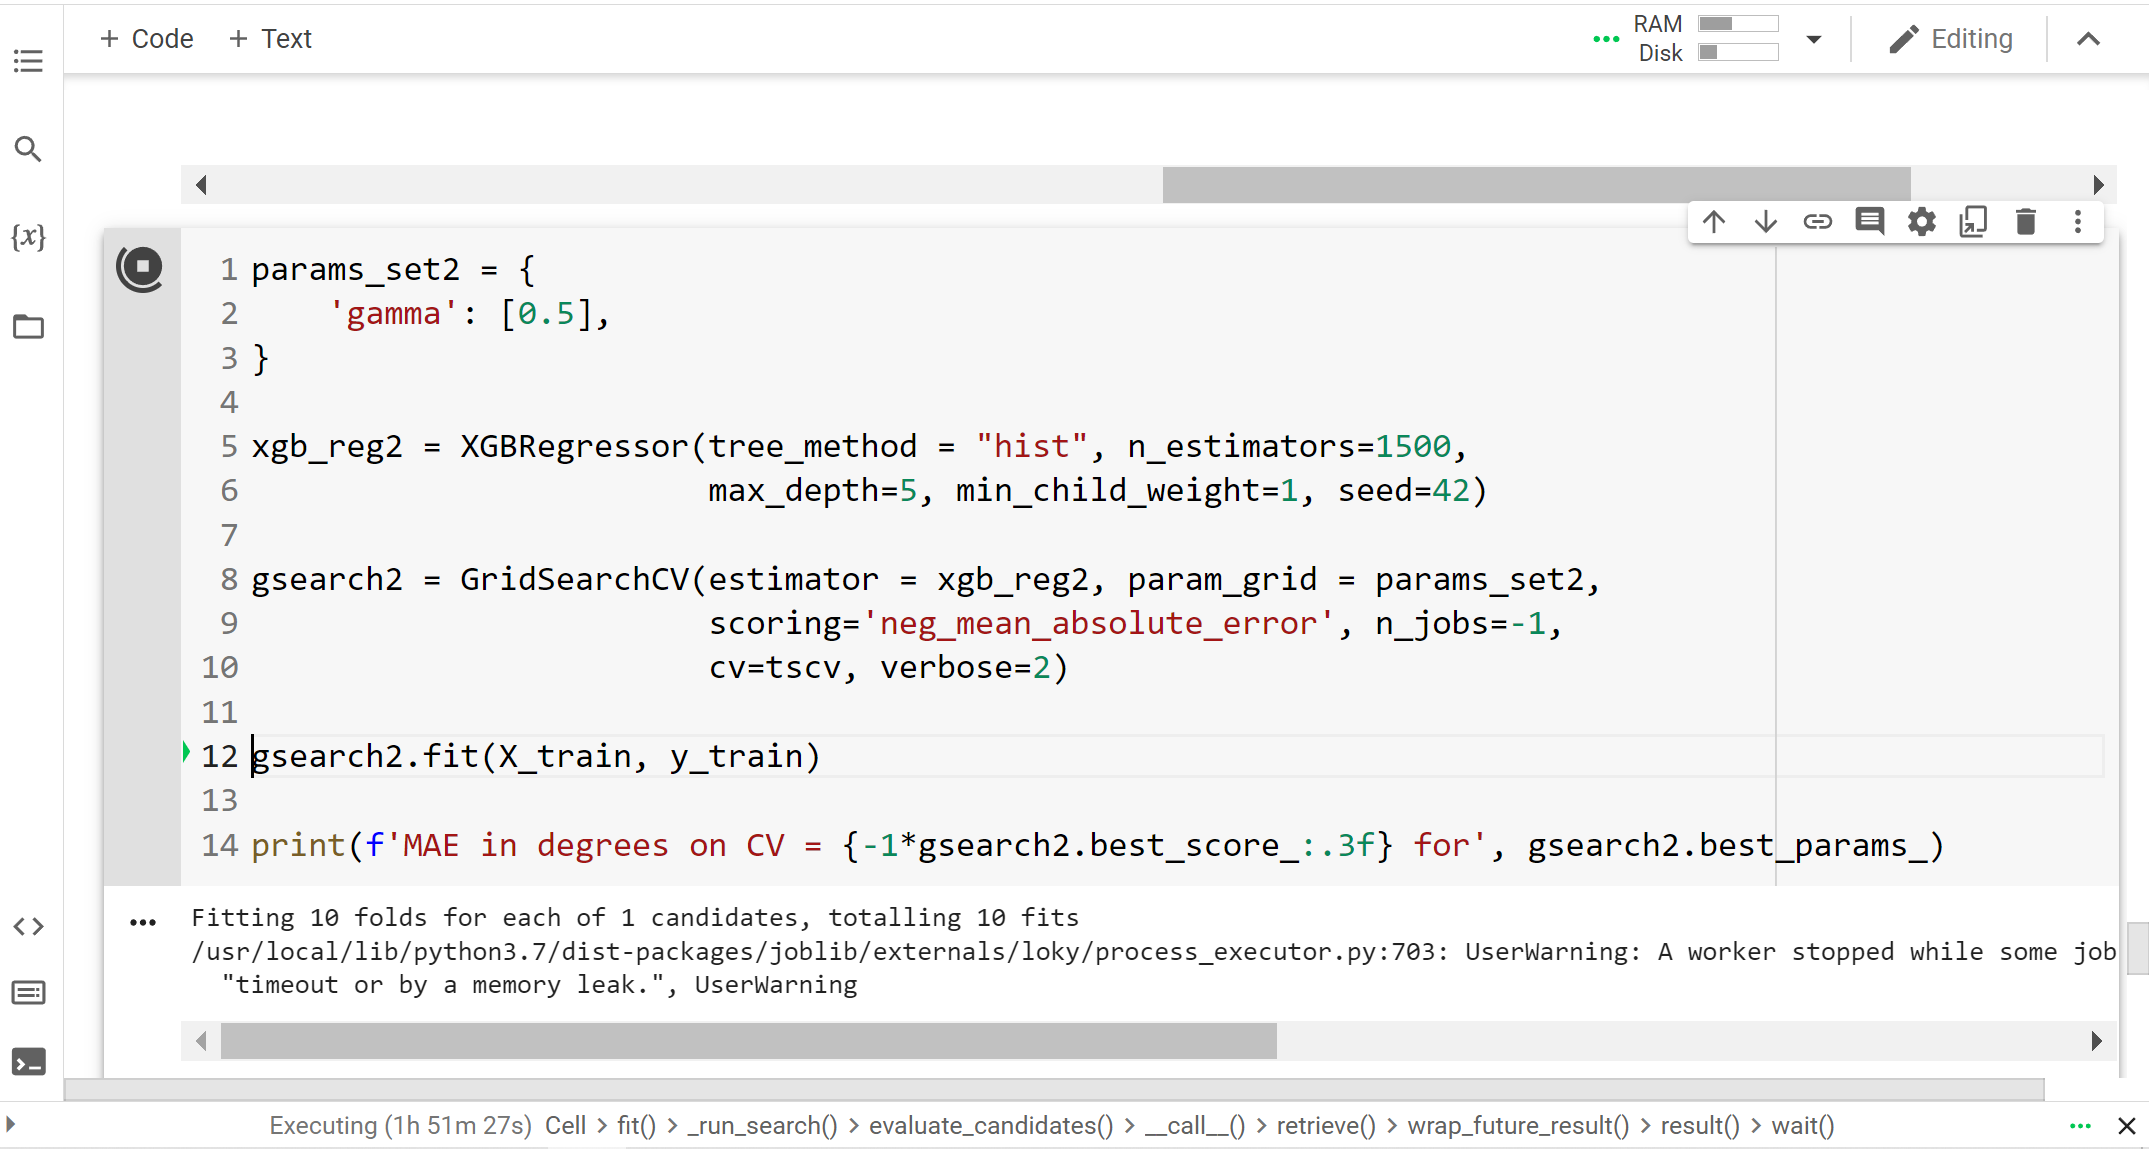

again n_estimators

In [ ]:
params_set3 = {
    'n_estimators' : [500, 1000]
}

xgb_reg3 = XGBRegressor(tree_method = "gpu_hist", n_estimators=1500,
                        max_depth=5, min_child_weight=1, gamma= ,
                        seed=42)

gsearch3 = GridSearchCV(estimator = xgb_reg3, param_grid = params_set3, 
                        scoring='neg_mean_absolute_error', n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch3.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch3.best_score_:.3f} for', gsearch3.best_params_)


In [ ]:
params_set4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb_reg3 = XGBRegressor(tree_method = "gpu_hist", seed=42)

gsearch3 = GridSearchCV(estimator = xgb_reg3, param_grid = params_set3, 
                        scoring='neg_mean_absolute_error', n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch3.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch3.best_score_:.3f} for', gsearch3.best_params_)


In [ ]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [ ]:
param_test6 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}

In [ ]:
params_set3 = {
    'n_estimators' : [50, 100, 200, 500]
}

xgb_reg3 = XGBRegressor(tree_method = "gpu_hist", seed=42)

gsearch3 = GridSearchCV(estimator = xgb_reg3, param_grid = params_set3, 
                        scoring='neg_mean_absolute_error', n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch3.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch3.best_score_:.3f} for', gsearch3.best_params_)


learning_rate = 0.01

In [ ]:
params_set3 = {
    'n_estimators' : [50, 100, 200, 500]
}

xgb_reg3 = XGBRegressor(tree_method = "gpu_hist", seed=42, learning_rate =0.01,
                        )

gsearch3 = GridSearchCV(estimator = xgb_reg3, param_grid = params_set3, 
                        scoring='neg_mean_absolute_error', n_jobs=-1, 
                        cv=tscv, verbose=2)

gsearch3.fit(X_train, y_train)

print(f'MAE in degrees on CV = {-1*gsearch3.best_score_:.3f} for', gsearch3.best_params_)

That's it. Now lets look on the performance on test set after training on the whole train set.

### Evaluation on test set

For optimal  xgb parameters that are listed below the obtained 


MAE in degrees on CV = 1.264

In [ ]:
xgb_reg = XGBRegressor(tree_method = "hist", n_estimators=1500,
                        max_depth=5, min_child_weight=1, seed=42)

xgb_reg.fit(X_train, y_train, verbose=True)

[17:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=5, n_estimators=1500, seed=42, tree_method='hist')

In [ ]:
mae = evaluate_with_mae(xgb_reg, X_test, y_test)
print(f'MAE in degrees (Test): {mae:.3f}')

MAE in degrees (Test): 1.172


MAE in degrees (Test): 1.172

In [ ]:
!ls

min_max_vals_lasso.pkl	       selected_features  weather.zip
project_Weather_station.ipynb  weather		  xgb_reg.pkl


In [ ]:
import pickle
file_name = "xgb_reg.pkl"
pickle.dump(xgb_reg, open(file_name, "wb"))

MAE in degrees (Test): 1.172

For XGBoost after tuning its parameters on the test set we get MAE = 1.172 (degrees) 


## Results:


In [ ]:
file_name = "xgb_reg.pkl"
xgb_loaded = pickle.load(open(file_name, "rb"))

file_name = "lin_reg.pkl"
lin_loaded = pickle.load(open(file_name, "rb"))

[21:06:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
X1, y1 = test_set_for_xgb()
print(X1.shape, y1.shape)

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]

(8592, 390) (8592,)


In [ ]:
X1 = X1.iloc[3:, :]
X1.head()

,berlin_blh_0,berlin_d2m_0,berlin_skt_0,berlin_sp_0,berlin_ssrd_0,berlin_t2m_0,berlin_tcc_0,berlin_tp_0,berlin_u10_0,berlin_v10_0,...,paris_blh_168,paris_d2m_168,paris_skt_168,paris_sp_168,paris_ssrd_168,paris_t2m_168,paris_tcc_168,paris_tp_168,paris_u10_168,paris_v10_168
time,,,,,,,,,,,,,,,,,,,,,
2019-01-08 03:00:00,920.936096,278.219391,278.335266,100147.015625,0.0,279.020996,0.929260,0.000226,5.462921,3.126755,...,270.462738,278.315552,278.765900,102257.906250,0.0,279.984344,0.940643,0.000014,1.603745,-0.233582
2019-01-08 04:00:00,955.272888,277.851593,278.263000,100024.671875,0.0,279.263031,0.988281,0.000225,5.859497,1.952103,...,129.607361,278.061615,278.362091,102230.078125,0.0,279.770386,0.954376,0.000005,1.806931,-0.162643
2019-01-08 05:00:00,956.332947,277.120331,277.839294,99900.500000,0.0,278.878052,0.900879,0.000231,5.888794,2.018814,...,125.921844,278.155640,278.459839,102174.765625,0.0,279.772583,0.980927,0.000006,2.025833,0.250549
2019-01-08 06:00:00,1063.722534,276.930786,277.513306,99776.640625,0.0,278.589630,0.973358,0.000013,6.212006,2.685226,...,168.567505,278.354797,278.758728,102159.703125,0.0,279.894348,0.982483,0.000007,2.155258,0.112274
2019-01-08 07:00:00,1122.611328,276.676270,277.332825,99646.812500,0.0,278.526855,0.991394,0.000173,6.594284,3.347458,...,161.892517,278.580933,278.819641,102187.171875,0.0,280.039215,0.999054,0.000005,2.189407,-0.288696


In [ ]:
xgb_pred = xgb_loaded.predict(X1.to_numpy())
xgb_pred.shape

(8589,)

In [ ]:
X2, y2 = test_set_for_lasso()
print(X2.shape, y2.shape)

100%|██████████| 5/5 [00:08<00:00,  1.78s/it]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


(8589, 203) (8589,)


In [ ]:
X2.head()

,berlin_blh_lag_1,berlin_blh_lag_25,berlin_blh_lag_49,berlin_blh_lag_73,berlin_blh_lag_97,berlin_blh_lag_121,berlin_blh_lag_145,berlin_blh_lag_169,berlin_d2m_lag_1,berlin_d2m_lag_25,...,paris_ssrd_lag_122,paris_ssrd_lag_146,paris_ssrd_lag_170,paris_t2m_lag_24,paris_t2m_lag_48,paris_t2m_lag_72,paris_t2m_lag_96,paris_t2m_lag_120,paris_t2m_lag_144,paris_t2m_lag_168
time,,,,,,,,,,,,,,,,,,,,,
2019-01-08 03:00:00,0.252395,0.018932,0.114146,0.198438,0.059095,0.172597,0.395804,0.269971,0.632310,0.521099,...,5.735011e-07,5.735011e-07,5.735011e-07,0.394497,0.366903,0.335070,0.314382,0.332546,0.391068,0.425493
2019-01-08 04:00:00,0.268444,0.028485,0.088217,0.200108,0.060799,0.167202,0.451285,0.315954,0.641898,0.524854,...,5.735011e-07,5.735011e-07,5.735011e-07,0.395713,0.361173,0.346433,0.308735,0.329360,0.389803,0.421571
2019-01-08 05:00:00,0.278559,0.035127,0.088924,0.205603,0.069418,0.176685,0.509397,0.341663,0.633929,0.528668,...,5.735011e-07,5.735011e-07,5.735011e-07,0.390790,0.361735,0.341415,0.303780,0.323808,0.392247,0.421611
2019-01-08 06:00:00,0.278872,0.035936,0.084046,0.206578,0.091066,0.185116,0.526911,0.332476,0.618086,0.533800,...,5.735011e-07,5.735011e-07,5.735011e-07,0.376782,0.364317,0.346269,0.306452,0.320754,0.389514,0.423843
2019-01-08 07:00:00,0.310507,0.034910,0.069612,0.214714,0.110951,0.190959,0.527500,0.296874,0.613979,0.540228,...,5.735011e-07,5.735011e-07,5.735011e-07,0.373577,0.362777,0.352258,0.301924,0.322968,0.384208,0.426499


In [ ]:
linreg_pred = lin_loaded.predict(X2.to_numpy())
linreg_pred.shape

(8589,)

In [ ]:
with open(r'min_max_vals_lasso.pkl', 'rb') as f:
    min_max_per_city = pickle.load(f)

paris_t2m_min = min_max_per_city['paris']['min']['t2m']
paris_t2m_max =  min_max_per_city['paris']['max']['t2m']

linreg_pred = linreg_pred *  (paris_t2m_max - paris_t2m_min) + paris_t2m_min

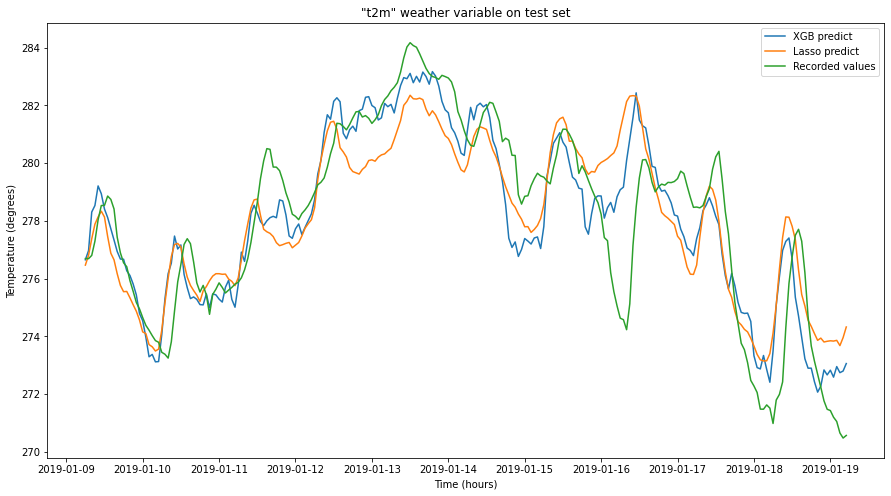

In [ ]:
import matplotlib.pyplot as plt

start_index = 30
len = 10*24

xs = y_test.index[start_index:start_index+len]

plt.figure(figsize=(15, 8))
plt.plot(xs, xgb_pred[start_index:start_index+len], label='XGB predict')
plt.plot(xs, linreg_pred[start_index:start_index+len], label='Lasso predict')
plt.plot(xs, y_test.to_numpy()[start_index:start_index+len], label='Recorded values')
plt.legend()
plt.title('"t2m" weather variable on test set')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (degrees)')
plt.show()


**Mean Absolute Error in degrees for predicting t2m temperature in Paris**



$$\hspace{2cm}$$

\begin{array}{ |c| c| c| }
\hline
    \text{Model / Data} & \text{Cross Validation} & \text{Test set}\\ 
\hline
    Lasso & 1.49 & 1.45 \\  
\hline
    XGB & 1.26 & 1.17 \\  
\hline  
\end{array}


So the best model allows us to infer t2m values that differ from ground truth at about 1.2 degrees (Celcius or Kelvin).

# Problem №2

As far as we don't have Paris data recorded at time moments close to the moment of prediction, the model will probably lose performance because data from Paris will not be used as features for regression.

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
from os.path import join as Path
import numpy as np
import xarray as xr
import pandas as pd

## Load datasets

In [ ]:
def evaluate_with_mae(model, X, y):
    y_pred = model.predict(X)
    diffs = np.abs(y_pred - y)
    mean = np.mean(diffs)
    return mean

def stack_all_vars(path_to_city_dir):
    # dir = 'weather/paris/'
    dir = path_to_city_dir
    list_of_files = ['blh.nc',	'd2m.nc',	'skt.nc',	'sp.nc',  'ssrd.nc',	
                    't2m.nc', 'tcc.nc',	'tp.nc',  'u10.nc',  'v10.nc']

    ds = xr.open_dataset(Path(base_dir, dir, list_of_files[0]))
    df = ds.to_dataframe()
    del ds
    df = df.droplevel([1, 2])
    df_with_all_vars = df
    del df

    for f in list_of_files[1:2]:
        ds = xr.open_dataset(Path(base_dir, dir, f))
        df = ds.to_dataframe()
        del ds
        df = df.droplevel([1, 2])
        df_with_all_vars = df_with_all_vars.join(df[df.columns[0]])
        del df

    for f in list_of_files[2:]:
        ds = xr.open_dataset(Path(base_dir, dir, f))
        df = ds.to_dataframe()
        del ds
        df = df.droplevel([0,1])
        df_with_all_vars = df_with_all_vars.join(df[df.columns[0]])
        del df
    
    df_with_all_vars = df_with_all_vars.dropna()
    return df_with_all_vars

def load_df_for_problem2(base_dir):
    city_names = ['berlin','brest','london','marseille','paris']

    lags_per_city = {}
    for city in city_names[:-1]:
        lags_per_city[city] = np.arange(0, 24*7+1, 24)
    lags_per_city['paris'] = []

    df_per_city = {}

    for city in tqdm(city_names):
        path_to_city_dir = Path(base_dir, 'weather', city)
        df = stack_all_vars(path_to_city_dir)
        df_per_city[city] = df

    target_features = ['t2m']
    dataset = df_per_city['paris'][target_features]

    lagged_dfs = []
    for city, df in zip(df_per_city.keys(), df_per_city.values()):
        tmp = df.copy()
        lags_in_hours = lags_per_city[city]
        for lag in lags_in_hours:
            tmp.columns = [city + '_' + feature + '_' + str(lag) for feature in df.columns]
            lagged_dfs.append(tmp.shift(lag))

    dataset = [dataset] + lagged_dfs
    del lagged_dfs
    dataset = pd.concat(dataset, axis=1)
    dataset = dataset.dropna()
    return dataset

In [ ]:
base_dir = '/content/drive/MyDrive/Projects/Projects4N/Energy_DS/Project_Weather_station'
df = load_df_for_problem2(base_dir)

100%|██████████| 5/5 [00:40<00:00,  8.04s/it]


In [ ]:
df.head(2)

,t2m,berlin_blh_0,berlin_d2m_0,berlin_skt_0,berlin_sp_0,berlin_ssrd_0,berlin_t2m_0,berlin_tcc_0,berlin_tp_0,berlin_u10_0,...,marseille_blh_168,marseille_d2m_168,marseille_skt_168,marseille_sp_168,marseille_ssrd_168,marseille_t2m_168,marseille_tcc_168,marseille_tp_168,marseille_u10_168,marseille_v10_168
time,,,,,,,,,,,,,,,,,,,,,
1980-01-08 07:00:00,274.280212,218.916534,265.765015,266.666626,101850.937500,0.0,266.715759,0.939026,0.000007,-1.898254,...,387.289490,272.332520,281.421631,99493.593750,0.0,277.095795,0.993958,0.0,4.349060,-4.645966
1980-01-08 08:00:00,274.166870,223.409088,265.630310,266.817200,101906.390625,24960.0,266.735229,0.925903,0.000006,-1.933716,...,382.825958,272.525757,281.682190,99442.953125,59392.0,277.131683,0.996643,0.0,4.844803,-3.940598


## Comparison of performance

Let's estimate the importance of the removed features by looking on the errors of XGB-regressors with default parameters trained with the two sets of features.

In [ ]:
def load_data_for_problem2(base_dir):
    city_names = ['berlin','brest','london','marseille','paris']

    lags_per_city = {}
    for city in city_names[:-1]:
        lags_per_city[city] = np.arange(0, 24*7+1, 24)
    # lags_per_city['paris'] cannot be used in problem 2
    lags_per_city['paris'] = []

    df_per_city_train = {}
    df_per_city_test = {}

    for city in tqdm(city_names):
        path_to_city_dir = Path(base_dir, 'weather', city)
        df = stack_all_vars(path_to_city_dir)

        df_per_city_train[city] = df.loc[df.index.year <= 2018]
        df_per_city_test[city] = df.loc[df.index.year == 2019]

    target_features = ['t2m']
    df_yX_train = df_per_city_train['paris'][target_features]
    list_of_train_sets = []
    for city, df in zip(df_per_city_train.keys(), df_per_city_train.values()):
        tmp = df.copy()
        lags_in_hours = lags_per_city[city]
        for lag in lags_in_hours:
            tmp.columns = [city + '_' + feature + '_' + str(lag) for feature in df.columns]
            list_of_train_sets.append(tmp.shift(lag))

    list_of_train_sets = [df_yX_train] + list_of_train_sets
    df_yX_train = pd.concat(list_of_train_sets, axis=1)
    df_yX_train.dropna()
    del df_per_city_train
    del list_of_train_sets
    y_train = df_yX_train['t2m'].to_numpy()
    X_train = df_yX_train.iloc[:, 1:].to_numpy()
    print('y_train with shape', y_train.shape)
    print('X_train with shape', X_train.shape)
    del df_yX_train

    df_yX_test = df_per_city_test['paris'][target_features]
    list_of_sets = []
    for city, df in zip(df_per_city_test.keys(), df_per_city_test.values()):
        tmp = df.copy()
        lags_in_hours = lags_per_city[city]
        for lag in lags_in_hours:
            tmp.columns = [city + '_' + feature + '_' + str(lag) for feature in df.columns]
            list_of_sets.append(tmp.shift(lag))

    list_of_sets = [df_yX_test] + list_of_sets
    df_yX_test = pd.concat(list_of_sets, axis=1)
    df_yX_test.dropna()
    del df_per_city_test
    del list_of_sets
    y_test = df_yX_test['t2m'].to_numpy()
    X_test = df_yX_test.iloc[:, 1:].to_numpy()
    print('y_test with shape', y_test.shape)
    print('X_test with shape', X_test.shape)
    del df_yX_test
    return X_train, y_train, X_test, y_test

In [ ]:
base_dir = '/content/drive/MyDrive/Projects/Project_Weather_station'
X_train, y_train, X_test, y_test = load_data_for_problem2(base_dir)

100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


y_train with shape (341873,)
X_train with shape (341873, 320)
y_test with shape (8760,)
X_test with shape (8760, 320)


To get a more representative assessment the cross-val errors will be used instead of test errors.

In [ ]:
n_splits = 10
val_fold_size = 365*24
train2val_ratio = 29

tscv = TimeSeriesSplit(n_splits= n_splits,
                       test_size= val_fold_size,
                       max_train_size= train2val_ratio * val_fold_size)

In [ ]:
xgb_reg = XGBRegressor(tree_method = "hist")

cv_scores = cross_val_score(xgb_reg, X_train, y_train,
                            scoring='neg_mean_absolute_error', 
                            cv=tscv, n_jobs=-1,
                            verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.2min finished


In [ ]:
print(f"MAE in degrees (CV):  {np.mean(-1*cv_scores):.3f} +/- {np.std(-1*cv_scores):.3f}\n")

MAE in degrees (CV):  1.536 +/- 0.069



For Problem #1 (with recent Paris data among features) we had 

MAE = 1.459 +/- 0.072 on CV for default XGB.

For Problem #2 (without recent Paris data among features) we have

MAE = 1.536 +/- 0.069 on CV for default XGB.


The difference is less than 0.1 degree that means that the real time information from other cities is enough to infer temperature in Paris. 

## Feature engineering

Let's add some features extracted from past weather recoreded in Paris to see if error can be reduced with the same XGB regressor parameters.

### Visualization of t2m (made before)

't2m' is plotted at different scales below.

As we see this variable has periods equal to one year and 24 hours.

In [ ]:
path_to_city_dir = Path(base_dir, 'weather', 'paris')
df_paris  = stack_all_vars(path_to_city_dir)

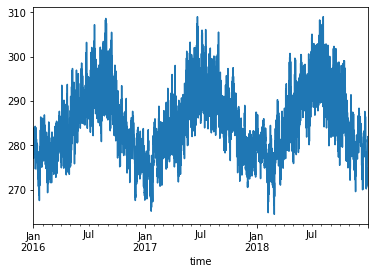

In [ ]:
import matplotlib.pyplot as plt

# nrows=1
# ncols=1
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

selected_features = ['t2m']

for i, feature in enumerate(selected_features):  
    # axes[i // ncols, i % ncols].set_title(feature + 'during a year')
    df_paris.loc[(df_paris.index.year==2018) | 
                 (df_paris.index.year==2017) |
                 (df_paris.index.year==2016), feature].plot( )

We see period equal to one year in the t2m plot above.

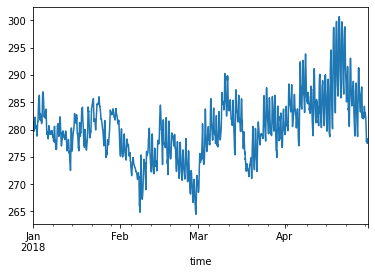

In [ ]:
import matplotlib.pyplot as plt

selected_features = ['t2m']

for i, feature in enumerate(selected_features):  
    df_paris.loc[(df_paris.index.year==2018) &
                 ((df_paris.index.month==1) |
                  (df_paris.index.month==2) |
                  (df_paris.index.month==3) |
                  (df_paris.index.month==4)), feature].plot( )

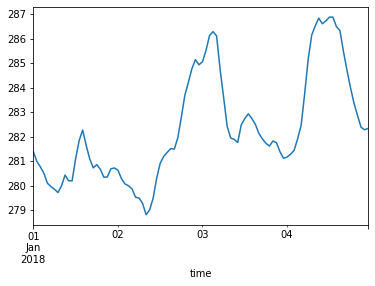

In [ ]:
for i, feature in enumerate(selected_features):  
    df_paris.loc[(df_paris.index.year==2018) &
                 (df_paris.index.month == 1) &
                 ((df_paris.index.day >= 1) & 
                  (df_paris.index.day <= 4) ), feature].plot()

The daily period can be seen.

### Adding new features

#### Cyclic time (month in year cycle and hour in day cycle)
Hour and month turned into splines vectors that make these features cyclic, i.e. with no gap between 23 and 0 hours and months 12 and 1.

In [ ]:
df.shape

(350465, 321)

We can try an alternative encoding of the periodic time-related features using spline transformations.

Idea borrowed from 
https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

In [ ]:
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

def add_cyclic_time(df):
    month2spline = periodic_spline_transformer(12, n_splines=6)
    hour2spline = periodic_spline_transformer(24, n_splines=12)

    new_month = month2spline.fit_transform(df.index.month.to_numpy().reshape(-1, 1))
    new_hour = hour2spline.fit_transform(df.index.hour.to_numpy().reshape(-1, 1))
    
    # print('new_month', new_month.shape)
    # print('new_hour', new_hour.shape)

    month_ = pd.DataFrame(new_month, columns = ['cyclic_month_'+str(i) for i in range(6)],
                          index=df.index)
    hour_ = pd.DataFrame(new_hour, columns = ['cyclic_hour_'+str(i) for i in range(12)],
                         index=df.index)
    
    new_df = pd.concat([df, month_, hour_], axis=1)
    return new_df

In [ ]:
df_with_time = add_cyclic_time(df)

In [ ]:
df_with_time.head(1)

,t2m,berlin_blh_0,berlin_d2m_0,berlin_skt_0,berlin_sp_0,berlin_ssrd_0,berlin_t2m_0,berlin_tcc_0,berlin_tp_0,berlin_u10_0,...,cyclic_hour_2,cyclic_hour_3,cyclic_hour_4,cyclic_hour_5,cyclic_hour_6,cyclic_hour_7,cyclic_hour_8,cyclic_hour_9,cyclic_hour_10,cyclic_hour_11
time,,,,,,,,,,,,,,,,,,,,,
1980-01-08 07:00:00,274.280212,218.916534,265.765015,266.666626,101850.9375,0.0,266.715759,0.939026,0.000007,-1.898254,...,0.0,0.020833,0.479167,0.479167,0.020833,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_with_time.shape

(350465, 339)

#### Mean value of t2m temperature

averaged over month before the prediction date in previous years could help predict the weather in this day this year.

##### Choose window size

Different window sizes, plots for year 2018.

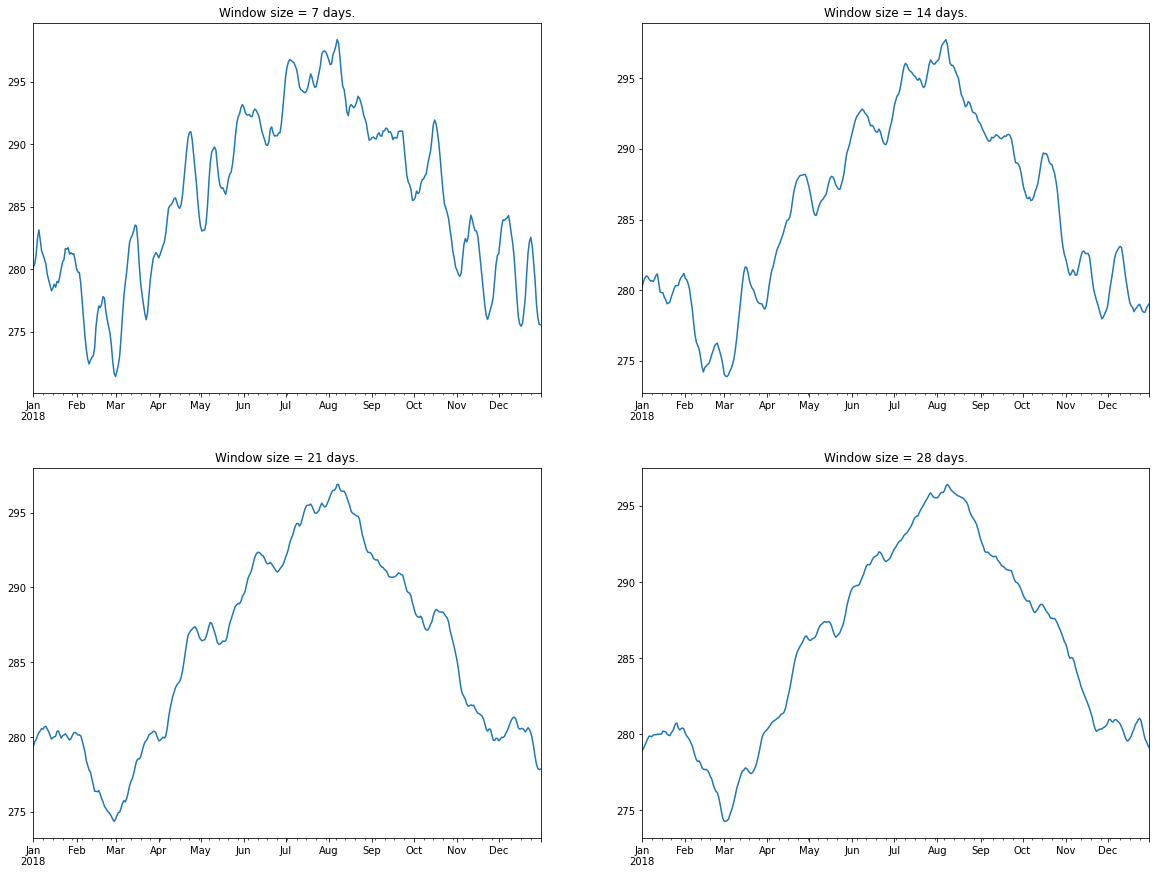

In [ ]:
from pandas import Timestamp
import matplotlib.pyplot as plt

nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))

for i, size in enumerate([7, 14, 21, 28]):
    axes[i // ncols, i % ncols].set_title('Window size = '+str(size)+ ' days.')
    tmp = df['t2m'].groupby([df.index.year, df.index.month, df.index.day]).mean().rolling(window=size).mean()
    tmp.index = [Timestamp( year=date[0], month = date[1], day=date[2]) for date in tmp.index]
    tmp.loc[tmp.index.year == 2018].plot(use_index=True, ax=axes[i // ncols, i % ncols])

Choosing smoothing window size by comparing plots for several consecutive years.

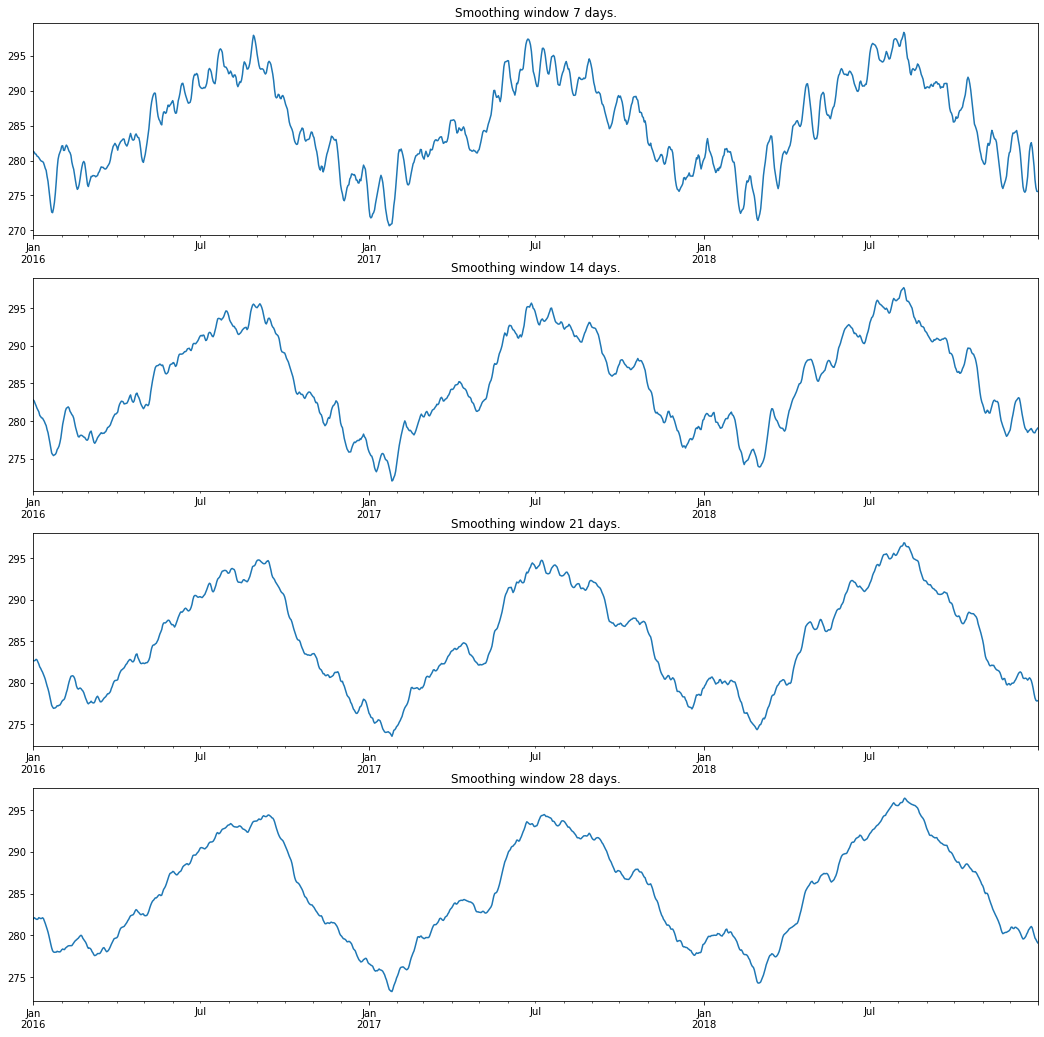

In [ ]:
from pandas import Timestamp
import matplotlib.pyplot as plt

nrows = 4
ncols = 1

list_years = [2016, 2017, 2018]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 18))

for i, size in enumerate([7, 14, 21, 28]):
    tmp = df['t2m'].groupby([df.index.year, df.index.month, df.index.day]).mean().rolling(window=size).mean()
    tmp.index = [Timestamp( year=date[0], month = date[1], day=date[2]) for date in tmp.index]
    axes[i].set_title(f'Smoothing window {str(size)} days.')
    tmp.loc[(tmp.index.year >= list_years[0]) & (tmp.index.year <= list_years[-1])].plot(
        use_index=True, ax=axes[i])


In [ ]:
%cd $base_dir
# plt.savefig('pics/windows.png')

In [ ]:
fig.savefig('pics/windows.png')

In [ ]:
!ls pics

paris_day.png  paris_month.png	paris_year.png	windows.png


We see that t2m value even after smoothing with 28 day long window still varies from year to year.


Thus mean monthly values of t2m will be calculated over one previous year for each day in the current year. 

##### Using window of length 28 days.

In [ ]:
def add_monthly_mean_feature(df, feature, window):
    lagged_feature = pd.DataFrame(df[feature].shift(365*24).rolling(
        window=window).mean() )
    lagged_feature.columns = [feature+'_lag_1y']
    new_df = pd.concat([df, lagged_feature], axis=1)
    new_df = new_df.dropna()
    return new_df

In [ ]:
df_with_time_mean_val = add_monthly_mean_feature(df_with_time, 't2m', 28*24)

In [ ]:
df_with_time_mean_val

,t2m,berlin_blh_0,berlin_d2m_0,berlin_skt_0,berlin_sp_0,berlin_ssrd_0,berlin_t2m_0,berlin_tcc_0,berlin_tp_0,berlin_u10_0,...,cyclic_hour_3,cyclic_hour_4,cyclic_hour_5,cyclic_hour_6,cyclic_hour_7,cyclic_hour_8,cyclic_hour_9,cyclic_hour_10,cyclic_hour_11,t2m_lag_1y
time,,,,,,,,,,,,,,,,,,,,,
1981-02-04 06:00:00,278.014526,423.007904,274.547516,274.885376,98358.859375,0.0,275.618042,1.000000,0.000159,2.597046,...,0.166667,0.666667,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,275.034860
1981-02-04 07:00:00,277.976959,496.211426,274.520752,274.796417,98301.250000,1792.0,275.584381,1.000000,0.000205,2.795334,...,0.020833,0.479167,0.479167,0.020833,0.000000,0.0,0.000000,0.000000,0.000000,275.045280
1981-02-04 08:00:00,277.642639,499.253784,274.641876,275.190125,98282.359375,66624.0,275.525452,1.000000,0.000321,3.144302,...,0.000000,0.166667,0.666667,0.166667,0.000000,0.0,0.000000,0.000000,0.000000,275.057202
1981-02-04 09:00:00,277.701782,515.713379,274.495819,275.736847,98223.843750,167040.0,275.291626,1.000000,0.000348,3.862198,...,0.000000,0.020833,0.479167,0.479167,0.020833,0.0,0.000000,0.000000,0.000000,275.069213
1981-02-04 10:00:00,278.726349,587.061279,275.112122,276.409058,98256.953125,307712.0,275.722443,1.000000,0.000297,4.669067,...,0.000000,0.000000,0.166667,0.666667,0.166667,0.0,0.000000,0.000000,0.000000,275.080421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,272.958130,598.160522,274.999390,276.230774,102599.195312,0.0,277.794067,0.185364,0.000002,4.072784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.020833,0.479167,0.479167,279.125492
2019-12-31 20:00:00,272.240845,502.529602,274.514282,276.089874,102615.515625,0.0,276.975220,0.151154,0.000000,3.867172,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.166667,0.666667,279.119849
2019-12-31 21:00:00,271.729919,455.757660,274.175903,275.173889,102653.062500,0.0,276.415466,0.110962,0.000000,3.471100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.020833,0.479167,279.114306


#### ARIMA

Parameters of autoregression model ARIMA fitted for t2m variable will describe this weather variable as time-series evolving through time.




##### Parameter of ARIMA

The (p,d,q) parameters are the order of the model for the autoregressive, differences, and moving average components

Let's choose 3 parameters for ARIMA model before fitting it on 't2m' weather variable. The intuition for parameter choosing is similar to the approach described in sources:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/





<Figure size 1224x576 with 0 Axes>

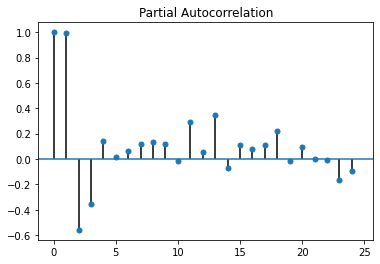

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(17, 8))

number_of_days = 1
plot_pacf(df['t2m'], lags= number_of_days*24)
plt.show()

The best order of the AR model is 3, because PACF values are high enough for lags 1, 2, 3.

<Figure size 1224x576 with 0 Axes>

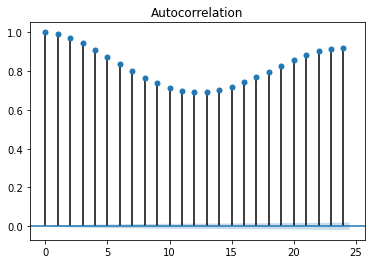

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(17, 8))

number_of_days = 1
plot_acf(df['t2m'], lags= number_of_days*24)
plt.show()

Probably, the optimal order of the MA model is 10, because ACF values are high enough for first 10 lags.

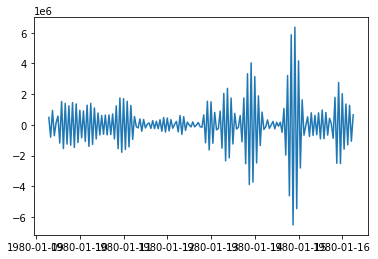

In [ ]:
from statsmodels.tsa.statespace.tools import diff

part_to_show = np.arange(24*7)

ts_diff = diff(df['t2m'], k_diff=24)

plt.plot(ts_diff[part_to_show])

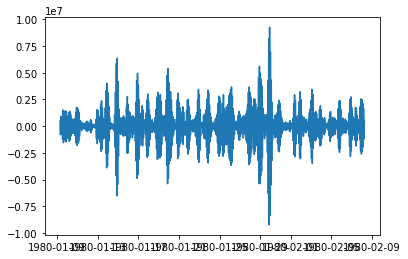

In [ ]:
plt.plot(ts_diff[np.arange(24*30)])

The differecing order of 24 removes the trend from time-series, but 2 is maximum allowed.

##### Choosing horizont length for ARIMA 

Let's experiment and look how well ARIMA with chosen parameters (3, 2, 10) fits the time series.

Model is fitted on each month of previous year.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

len_train = 365*24
train_set = df['t2m'].to_numpy()[:len_train]
model = ARIMA(train_set, order=(3, 2, 10))
results = model.fit()
fitted = results.fittedvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


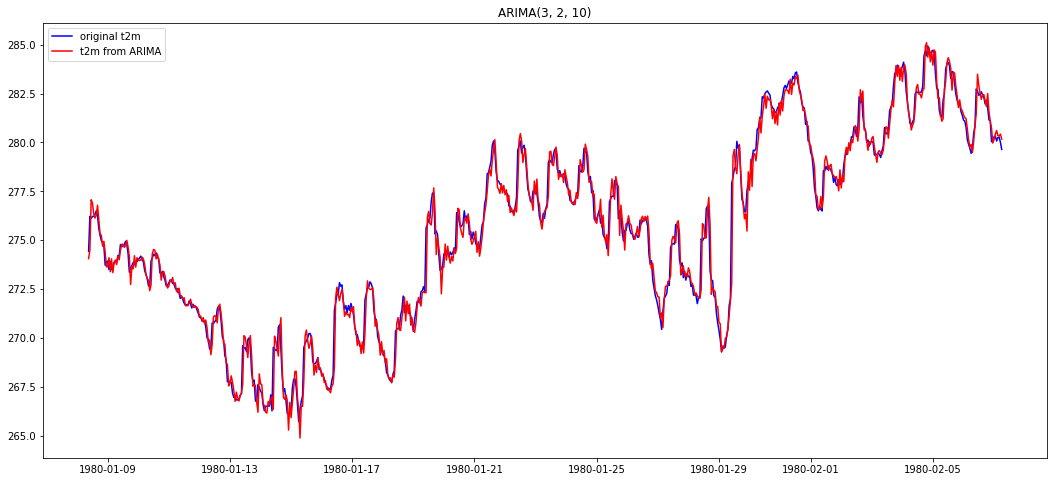

In [ ]:
show_ids = 24*30

plt.figure(figsize=(18, 8))

xs = df.index[2:show_ids]
plt.plot(xs, train_set[2:show_ids], color='blue', label='original t2m')
plt.plot(xs, fitted[2:show_ids], color='red', label='t2m from ARIMA')

plt.title('ARIMA(3, 2, 10) fitted on a year-long times series.')
plt.legend()
plt.show()

In [ ]:
np.mean(np.abs(train_set[2:show_ids] - fitted[2:show_ids]))

0.41422706855469

In [ ]:
results.polynomial_ar

array([ 1.        ,  1.29175904, -0.22730779, -0.62997997])

In [ ]:
results.polynomial_ma

array([ 1.        ,  0.57141663, -1.22049807, -0.59343518,  0.18100362,
       -0.334858  ,  0.01111328, -0.02905593, -0.1805579 ,  0.29409093,
        0.30170949])

In [ ]:
results.polynomial_seasonal_ar

array([1.])

In [ ]:
results.polynomial_seasonal_ma

array([1.])

In [ ]:
results.polynomial_trend

array([], dtype=float64)

In [ ]:
results.param_terms

['ar', 'ma', 'variance']

Now I'll do the same but for a month

In [ ]:
%%timeit

len_train = 28*24
train_set = df['t2m'].to_numpy()[:len_train]
model = ARIMA(train_set, order=(3, 2, 10))
results = model.fit()
fitted = results.fittedvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

6.23 s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


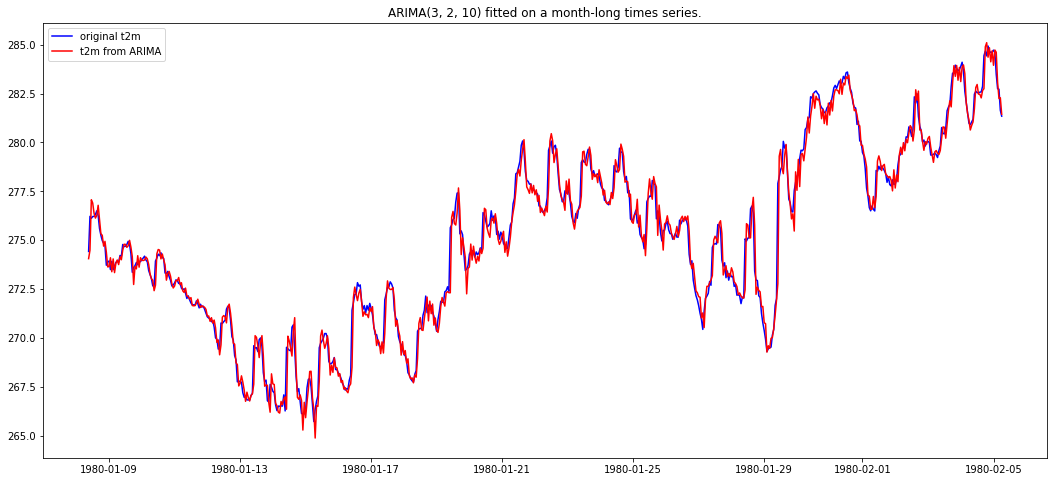

In [ ]:
show_ids = 28*24

plt.figure(figsize=(18, 8))

xs = df.index[2:show_ids]
plt.plot(xs, train_set[2:show_ids], color='blue', label='original t2m')
plt.plot(xs, fitted[2:show_ids], color='red', label='t2m from ARIMA')

plt.title('ARIMA(3, 2, 10) fitted on a month-long times series.')
plt.legend()
plt.show()

In [ ]:
np.mean(np.abs(train_set[2:show_ids] - fitted[2:show_ids]))

0.4192896772471976

As we can see ARIMA fits time series of one month length with almost the same MAE as for one year ong TS.

One month interval is comprises the change of t2m trend during the year, i.e. there are both decreasing and uncreasing slopes near local extrema in one month period.

So  results.polynomial_ar and results.polynomial_ma can be used as features to reflect monthly TS evolution. First ARIMA is fitted on a month before current and a year ago and than its parameters will ne features for all datetimes in current month.

##### Parameters of ARIMA on same month a year ago

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

def add_ARIMA_weights_for_feature(df, feature, window):

    features = []
    feature_horizont = df[feature].to_numpy()
    num_windows_per_year = 365*24 // window
    if 365*24 % window >= window // 2:
        num_windows_per_year += 1

    start_time = df.shape[0] % (num_windows_per_year * window)
    # print('start_time', start_time)
    # print('total years', df.shape[0] // (num_windows_per_year * window))

    start_ids_range = range(start_time,
                            df.shape[0] - num_windows_per_year * window, window)

    ids_to_take = df.index[start_time + num_windows_per_year * window :]
    assert len(start_ids_range)*window == len(ids_to_take)

    # print('ids_to_take in years', len(ids_to_take) / num_windows_per_year / window)

    for start_of_train_set in tqdm(start_ids_range):
        train_set = feature_horizont[start_of_train_set: start_of_train_set + window]
        model = ARIMA(train_set, order=(3, 2, 10))
        results = model.fit()
        # print(results.polynomial_ar.shape)
        # print(results.polynomial_ma.shape)
        feature_vector = np.concatenate(
            [results.polynomial_ar, results.polynomial_ma]).reshape((1, -1))
        # print('feature_vector', feature_vector.shape)
        monthly_features = np.tile(feature_vector, (window, 1) )
        # print('monthly_features', monthly_features.shape)
        features.append(monthly_features)

    features = np.concatenate(features, axis=0)
    # print('features', features.shape)

    new_features = pd.DataFrame(features,
                                index = ids_to_take, 
                                columns=['arima_'+str(i) for i in range(features.shape[1]) ])
    # print('new_features', new_features.shape)
    new_df = pd.concat([df, new_features], axis=1)
    new_df = new_df.dropna()
    return new_df

In [ ]:
df_with_time_mean_val_arima =  add_ARIMA_weights_for_feature(
                                    df_with_time_mean_val, 't2m', 28*24)

  0%|          | 0/494 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 1/494 [00:10<1:25:09, 10.36s/it]/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile

In [ ]:
%cd '/content/drive/MyDrive/Projects/Projects4N/Energy_DS/Project_Weather_station'

/content/drive/MyDrive/Projects/Projects4N/Energy_DS/Project_Weather_station


In [ ]:
df_with_time_mean_val_arima.to_csv('df_with_time_mean_val_arima.csv')

In [ ]:
!ls

df_with_time_mean_val_arima.csv  project_Weather_station.ipynb	weather
lin_reg.pkl			 selected_features		weather.zip
min_max_vals_lasso.pkl		 test.csv			xgb_reg.pkl
pics				 test.gsheet


In [ ]:
df_with_time_mean_val_arima.head()

,t2m,berlin_blh_0,berlin_d2m_0,berlin_skt_0,berlin_sp_0,berlin_ssrd_0,berlin_t2m_0,berlin_tcc_0,berlin_tp_0,berlin_u10_0,...,arima_5,arima_6,arima_7,arima_8,arima_9,arima_10,arima_11,arima_12,arima_13,arima_14
time,,,,,,,,,,,,,,,,,,,,,
1982-02-17 00:00:00,275.048767,279.741760,272.245544,272.808899,101894.968750,0.0,273.316345,0.983765,1.907349e-06,-3.205902,...,-0.382377,0.148949,0.53179,-0.710366,-0.202385,-0.001853,-0.112077,-0.25539,0.145538,-0.161662
1982-02-17 01:00:00,275.041931,256.466705,272.207733,272.486328,101892.734375,0.0,273.151306,0.992584,1.430511e-06,-2.938828,...,-0.382377,0.148949,0.53179,-0.710366,-0.202385,-0.001853,-0.112077,-0.25539,0.145538,-0.161662
1982-02-17 02:00:00,274.743042,248.601639,272.127838,272.280090,101874.984375,0.0,273.053589,0.980011,9.536743e-07,-2.977219,...,-0.382377,0.148949,0.53179,-0.710366,-0.202385,-0.001853,-0.112077,-0.25539,0.145538,-0.161662
1982-02-17 03:00:00,274.659424,238.026123,271.811279,272.141296,101852.156250,0.0,272.719971,0.910767,4.768372e-07,-3.033691,...,-0.382377,0.148949,0.53179,-0.710366,-0.202385,-0.001853,-0.112077,-0.25539,0.145538,-0.161662
1982-02-17 04:00:00,274.852509,232.596588,271.404846,271.836365,101855.765625,0.0,272.305634,0.741577,0.000000e+00,-2.953064,...,-0.382377,0.148949,0.53179,-0.710366,-0.202385,-0.001853,-0.112077,-0.25539,0.145538,-0.161662


In [ ]:
# df_test = pd.read_csv('test.csv', index_col=0, parse_dates=True)

In [ ]:
# df_test.equals(df_with_arima)

False

In [ ]:
# df_test.shape

(8736, 336)

In [ ]:
# df_with_arima.shape

(8736, 336)

## Model training

In [ ]:
def get_dataset_from_df_augmented(df):
    df_train = df.loc[df.index.year <= 2018]
    df_test = df.loc[df.index.year == 2019]

    y_train = df_train['t2m'].to_numpy()
    X_train = df_train.iloc[:, 1:].to_numpy()
    y_test = df_test['t2m'].to_numpy()
    X_test = df_test.iloc[:, 1:].to_numpy()

    print('y_train with shape', y_train.shape)
    print('X_train with shape', X_train.shape)
    print()
    print('y_test with shape', y_test.shape)
    print('X_test with shape', X_test.shape)
    return X_train, y_train, X_test, y_test

def evaluate_with_mae(model, X, y):
    y_pred = model.predict(X)
    diffs = np.abs(y_pred - y)
    mean = np.mean(diffs)
    return mean

In [ ]:
df_with_time_mean_val_arima = pd.read_csv('df_with_time_mean_val_arima.csv',
                                          index_col=0, parse_dates=True)

In [ ]:
print(' '.join(df_with_time_mean_val_arima.columns))

t2m berlin_blh_0 berlin_d2m_0 berlin_skt_0 berlin_sp_0 berlin_ssrd_0 berlin_t2m_0 berlin_tcc_0 berlin_tp_0 berlin_u10_0 berlin_v10_0 berlin_blh_24 berlin_d2m_24 berlin_skt_24 berlin_sp_24 berlin_ssrd_24 berlin_t2m_24 berlin_tcc_24 berlin_tp_24 berlin_u10_24 berlin_v10_24 berlin_blh_48 berlin_d2m_48 berlin_skt_48 berlin_sp_48 berlin_ssrd_48 berlin_t2m_48 berlin_tcc_48 berlin_tp_48 berlin_u10_48 berlin_v10_48 berlin_blh_72 berlin_d2m_72 berlin_skt_72 berlin_sp_72 berlin_ssrd_72 berlin_t2m_72 berlin_tcc_72 berlin_tp_72 berlin_u10_72 berlin_v10_72 berlin_blh_96 berlin_d2m_96 berlin_skt_96 berlin_sp_96 berlin_ssrd_96 berlin_t2m_96 berlin_tcc_96 berlin_tp_96 berlin_u10_96 berlin_v10_96 berlin_blh_120 berlin_d2m_120 berlin_skt_120 berlin_sp_120 berlin_ssrd_120 berlin_t2m_120 berlin_tcc_120 berlin_tp_120 berlin_u10_120 berlin_v10_120 berlin_blh_144 berlin_d2m_144 berlin_skt_144 berlin_sp_144 berlin_ssrd_144 berlin_t2m_144 berlin_tcc_144 berlin_tp_144 berlin_u10_144 berlin_v10_144 berlin_blh_16

In [ ]:
X_train, y_train, X_test, y_test = get_dataset_from_df_augmented(df_with_time_mean_val_arima)

y_train with shape (323208,)
X_train with shape (323208, 354)

y_test with shape (8760,)
X_test with shape (8760, 354)


In [ ]:
# 323208 + 8760 == df_with_time_mean_val_arima.shape[0]

In [ ]:
n_splits = 10
val_fold_size = 365*24
train2val_ratio = 29

tscv = TimeSeriesSplit(n_splits= n_splits,
                       test_size= val_fold_size,
                       max_train_size= train2val_ratio * val_fold_size)

### Firstly, XGB regressor with default params is fitted to check the impact of added features.

In [ ]:
xgb_reg = XGBRegressor(tree_method = "hist")

cv_scores = cross_val_score(xgb_reg, X_train, y_train,
                            scoring='neg_mean_absolute_error', 
                            cv=tscv, n_jobs=-1,
                            verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.5min finished


In [ ]:
print(f"MAE in degrees (CV):  {np.mean(-1*cv_scores):.3f} +/- {np.std(-1*cv_scores):.3f}\n")

MAE in degrees (CV):  1.505 +/- 0.067



MAE in degrees (CV):  1.505 +/- 0.067

### Next, tune n_estimators of XGB with cross-validation

#### n_estimators=1500

5 min to run this cell:

In [ ]:
xgb_reg1 = XGBRegressor(tree_method = "gpu_hist", seed=42, n_estimators=1500)


cv_scores = cross_val_score(xgb_reg1, X_train, y_train,
                            scoring='neg_mean_absolute_error', 
                            cv=tscv, n_jobs=-1,
                            verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.5min finished


In [ ]:
print(f"MAE in degrees (CV):  {np.mean(-1*cv_scores):.3f} +/- {np.std(-1*cv_scores):.3f}\n")

MAE in degrees (CV):  1.350 +/- 0.051



MAE in degrees (CV):  1.350 +/- 0.051

#### params that were optimal in problem 1

In [ ]:
xgb_reg2 = XGBRegressor(tree_method = "gpu_hist", n_estimators=1500,
                        max_depth=5, min_child_weight=1, seed=42)

cv_scores = cross_val_score(xgb_reg2, X_train, y_train,
                            scoring='neg_mean_absolute_error', 
                            cv=tscv, n_jobs=-1,
                            verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.3min finished


In [ ]:
print(f"MAE in degrees (CV):  {np.mean(-1*cv_scores):.3f} +/- {np.std(-1*cv_scores):.3f}\n")

MAE in degrees (CV):  1.324 +/- 0.056



MAE in degrees (CV):  1.324 +/- 0.056

## Evaluation on test set

In [ ]:
xgb_reg2 = XGBRegressor(tree_method = "gpu_hist", n_estimators=1500,
                        max_depth=5, min_child_weight=1, seed=42)

xgb_reg2.fit(X_train, y_train, verbose=True)

[12:13:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=5, n_estimators=1500, seed=42, tree_method='gpu_hist')

In [ ]:
mae = evaluate_with_mae(xgb_reg2, X_test, y_test)
print(f'MAE in degrees (Test): {mae:.3f}')

MAE in degrees (Test): 1.221


MAE in degrees (Test): 1.221

In [ ]:
import pickle
file_name = "xgb_reg2_problem_2.pkl"
pickle.dump(xgb_reg2, open(file_name, "wb"))

In [ ]:
# import pickle
# file_name = "xgb_reg_problem_2.pkl"
# pickle.dump(xgb_reg, open(file_name, "wb"))

In [ ]:
!ls

df_with_time_mean_val_arima.csv  selected_features  xgb_reg2_problem_2.pkl
lin_reg.pkl			 test.csv	    xgb_reg.pkl
min_max_vals_lasso.pkl		 test.gsheet	    xgb_reg_problem_2.pkl
pics				 weather
project_Weather_station.ipynb	 weather.zip


## Results:


Old part:

In [ ]:
file_name = "xgb_reg.pkl"
xgb_loaded = pickle.load(open(file_name, "rb"))

# file_name = "lin_reg.pkl"
# lin_loaded = pickle.load(open(file_name, "rb"))

[12:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
X1, y1 = test_set_for_xgb()
print(X1.shape, y1.shape)

100%|██████████| 5/5 [00:42<00:00,  8.48s/it]

(8592, 390) (8592,)


In [ ]:
X1 = X1.iloc[3:, :]
# X1.head()

In [ ]:
xgb_pred = xgb_loaded.predict(X1.to_numpy())
xgb_pred.shape

(8589,)

In [ ]:
# X2, y2 = test_set_for_lasso()
# print(X2.shape, y2.shape)

100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


(8589, 203) (8589,)


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [ ]:
# linreg_pred = lin_loaded.predict(X2.to_numpy())
# linreg_pred.shape

(8589,)

In [ ]:
# with open(r'min_max_vals_lasso.pkl', 'rb') as f:
#     min_max_per_city = pickle.load(f)

# paris_t2m_min = min_max_per_city['paris']['min']['t2m']
# paris_t2m_max =  min_max_per_city['paris']['max']['t2m']

# linreg_pred = linreg_pred *  (paris_t2m_max - paris_t2m_min) + paris_t2m_min

New part:

In [ ]:
# file_name = "xgb_reg_problem_2.pkl"
# xgb_reg = pickle.load(open(file_name, "rb"))

In [ ]:
def get_test_dfs_to_plot(df):
    df_train = df.loc[df.index.year <= 2018]
    df_test = df.loc[df.index.year == 2019]

    y_test = df_test['t2m']
    X_test = df_test.iloc[:, 1:]

    print('y_test with shape', y_test.shape)
    print('X_test with shape', X_test.shape)
    return X_test, y_test

X3, y3 = get_test_dfs_to_plot(df_with_time_mean_val_arima)

y_test with shape (8760,)
X_test with shape (8760, 354)


In [ ]:
start_index = 30
len = 10*24

xs = y1.index[start_index:start_index+len]

In [ ]:
xgb_p2_pred2plot = xgb_reg2.predict(X3.loc[xs[0]:xs[-1]].to_numpy())
xgb_p2_pred2plot.shape

(240,)

Plot:

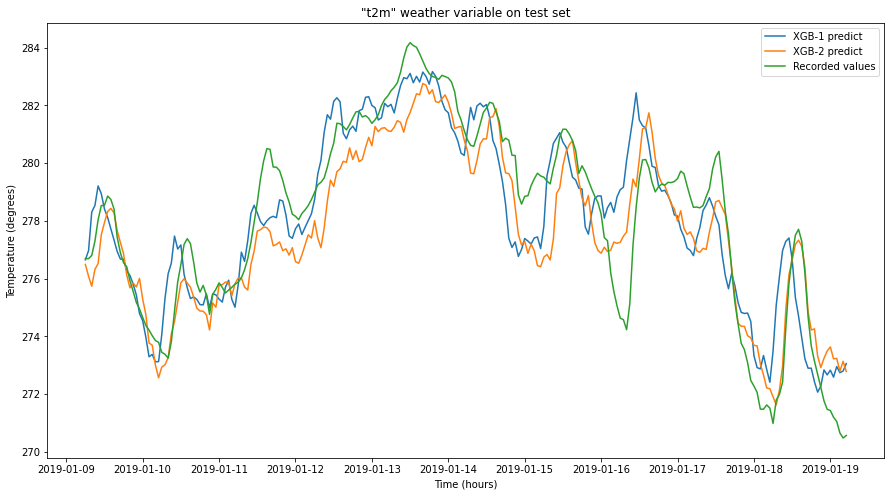

In [ ]:
import matplotlib.pyplot as plt

start_index = 30
len = 10*24
xs = y1.index[start_index:start_index+len]

plt.figure(figsize=(15, 8))
plt.plot(xs, xgb_pred[start_index:start_index+len], label='XGB-1 predict')
plt.plot(xs, xgb_p2_pred2plot, label='XGB-2 predict')

# plt.plot(xs, linreg_pred[start_index:start_index+len], label='Lasso predict')
plt.plot(xs, y1.to_numpy()[start_index:start_index+len], label='Recorded values')
plt.legend()
plt.title('"t2m" weather variable on test set')
plt.xlabel('Time (hours)')
plt.ylabel('Temperature (degrees)')

plt.savefig('pics/plot2.png')
plt.show()

In [ ]:
!ls pics

paris_day.png	 paris_year.png  problem_2.png
paris_month.png  plot2.png	 windows.png


### Feature impact



**MAE in degrees for predicting t2m temperature in Paris with XGB regressor with default parameters**



$$\hspace{2cm}$$

\begin{array}{ |c| c| }
\hline
    \text{Model / Data} & \text{Cross Validation} \\ 
\hline
    \text{feature set 1} & 1.45\\  
\hline
    \text{feature set 2} & 1.53 \\  
\hline 
    \text{feature set 3} & 1.50 \\  
\hline  
\end{array}


feature set 1 is from problem 1 with recent Paris data.

feature set 2 is after removing Paris features from feature set 1.

feature set 3 is feature set 2 after adding new features: cyclic time, mean of month a year ago and coefficients of ARIMA fitted over month a year ago.